# Univariate LSTM:
#### INPUT: current
#### Output: voltage
#### Uses static -> dynamic-> static cylces as training data

In [2]:
%reload_ext autoreload
# for auto reloading modules without kernel restart
# If this does not work to import custom modules, then restart kernel

In [3]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_12132\696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from datetime import timedelta
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.2
numpy version: 1.21.5


In [5]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [6]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive
# constants for plotting
x_label_elapsedtime = 0
x_label_datetime = 1

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
import seaborn as sns

### Load processed time series static-dynamic-static cycle samples with cell IDs
It is a list of valid charge/discharge/dynamic cycles with static voltage in the beginning and end

In [12]:
# Load processed data (phase 1)
import pickle
    
# load last saved df from phase1 data and convert time stamp and sort
dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'cell_cycles.pkl')

with open(src_path, 'rb') as f:
    li_ts_cycles_ph1 = pickle.load(f)

In [13]:
# Load processed data (phase 2)
import pickle

# load last saved df from phase1 data and convert time stamp and sort
dir_path = os.path.join(cwd, 'csv', 'phase_2_pkl')
src_path = os.path.join(dir_path, 'mod1_cell_cycles.pkl')

with open(src_path, 'rb') as f:
    li_ts_cycles_ph2 = pickle.load(f)

In [14]:
# Combine phase1 and phase 2 data
import math

# for x, y in li_ts_cycles_ph1:
#     print('phase1 cells', len(y))
    
# for x, y in li_ts_cycles_ph2:
#     print('phase2 cells', len(y))

combined_phase_cycles = []
if len(li_ts_cycles_ph1) <= len(li_ts_cycles_ph2):
    for i in range(len(li_ts_cycles_ph1)):              # each cell contain multiple cycles
        c_1, cycles_1 = li_ts_cycles_ph1[i]                 # for example, (v1, [cycles])
        c_2, cycles_2 = li_ts_cycles_ph2[i]
        if (c_2 == c_1):
            cycles_1 += cycles_2                        # this adds cycle to li_ts_cycles_ph1
    combined_phase_cycles = li_ts_cycles_ph1
else:
    for i in range(len(li_ts_cycles_ph2)):              # each cell contain multiple cycles
        c_2, cycles_2 = li_ts_cycles_ph2[i]
        c_1, cycles_1 = li_ts_cycles_ph1[i]
        if (c_2 == c_1):
            cycles_2 += cycles_1                        # this adds cycle to li_ts_cycles
    combined_phase_cycles = li_ts_cycles_ph2


# for x, y in combined_phase_cycles:
#     print('combined cells', len(y))

## Experiment 1: take only one cell and see how the algorithm performs

In [15]:
import math

# Separate training, validation and test cycles, keep cycles without cell ID
TRAIN_SAMPLES = 0.9
li_train_cycles = []      # each of this list is a separate static_dynamic_static cycle
# li_validation_cycles = []
li_test_cycles= []

total_cycles = 0
for (c, li_cycles) in combined_phase_cycles:              # each cell contain multiple cycles
    num_cell_cycles = len(li_cycles)
    num_train_cycles = math.floor(num_cell_cycles * TRAIN_SAMPLES)                 # training cycle samples 70%
    # num_validation_cycles = math.ceil((num_cell_cycles - num_train_cycles) * 0.5)
    # num_test_cycles = num_cell_cycles - num_validation_cycles - num_train_cycles
    num_test_cycles = num_cell_cycles - num_train_cycles
    total_cycles += len(li_cycles)
    # print(num_cell_cycles, num_train_cycles, num_validation_cycles, num_test_cycles)

    li_train_cycles += li_cycles[0:num_train_cycles]
    # li_validation_cycles += li_cycles[num_train_cycles:num_train_cycles+num_validation_cycles]
    # li_test_cycles += li_cycles[num_train_cycles+num_validation_cycles:]
    li_test_cycles += li_cycles[num_train_cycles:]
    break

print(total_cycles, len(li_train_cycles), len(li_test_cycles))     # test

17 15 2


#### Plot all the training data

<IPython.core.display.Javascript object>


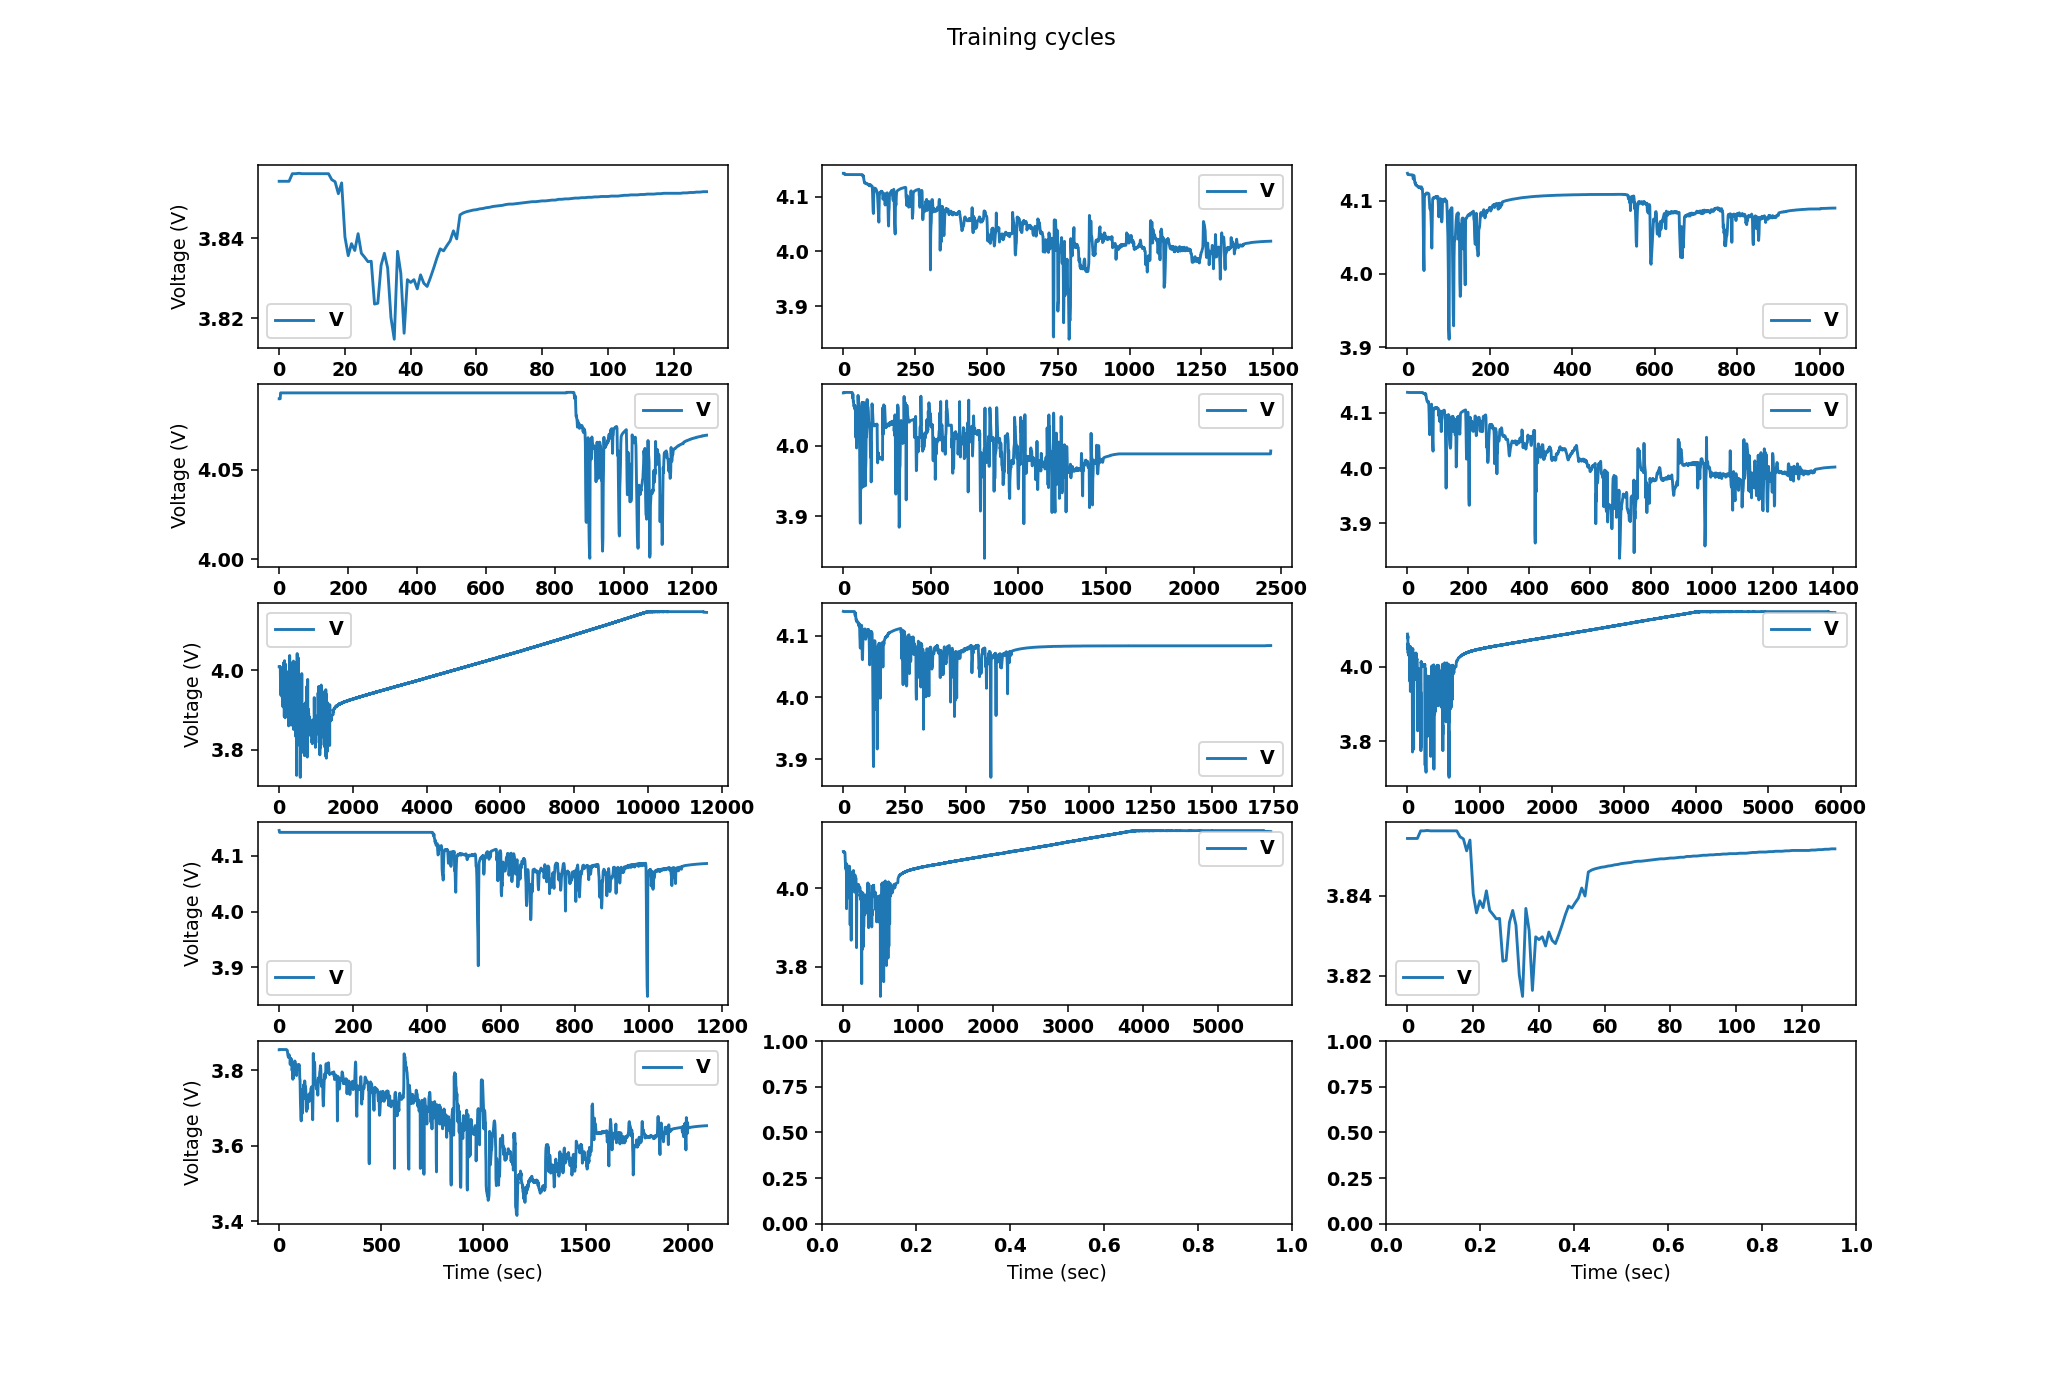

i:  0   j:  0
i:  0   j:  1
i:  0   j:  2
i:  1   j:  0
i:  1   j:  1
i:  1   j:  2
i:  2   j:  0
i:  2   j:  1
i:  2   j:  2
i:  3   j:  0
i:  3   j:  1
i:  3   j:  2
i:  4   j:  0


In [44]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set save path for plot
fig_path = os.path.join(cwd, 'figures')
plot_path = os.path.join(fig_path, 'train_cycles_voltages.pdf')

cols = 3
total_train_cycles = len(li_train_cycles)
rows = math.ceil(total_train_cycles / cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

i = -1        # row index
j = 0        # col index
# Plot multiple train cycles voltages
for df in li_train_cycles:
    if (j % cols == 0):
        j = 0
        i += 1     # first entrance makes i = 0
    print('i: ', i, '  j: ', j)
    df_each = df.copy()
    df_each.plot(x='elapsed_sec', y='V', ax = axes[i][j], title='Training cycles', subplots=True)
#     ax.set_title(f'Title {i}')
    j += 1

# set labels
plt.setp(axes[-1, :], xlabel='Time (sec)')
plt.setp(axes[:, 0], ylabel='Voltage (V)')
plt.show()
plt.savefig(plot_path)

#### Remove cylces from the li_train_cycles list that seems corrupted based on viewing previous plot
**caution: run the following cell (hidden) exactly once**

In [43]:
del li_train_cycles[3]   # first delete the higher index, very important
del li_train_cycles[1]

### Show current and voltage relationship
1. Show both values vs time (first plot below)
2. Show correlation (second plot below)
3. Show autocorrelation of voltage (based on lag, third plot below)

<IPython.core.display.Javascript object>


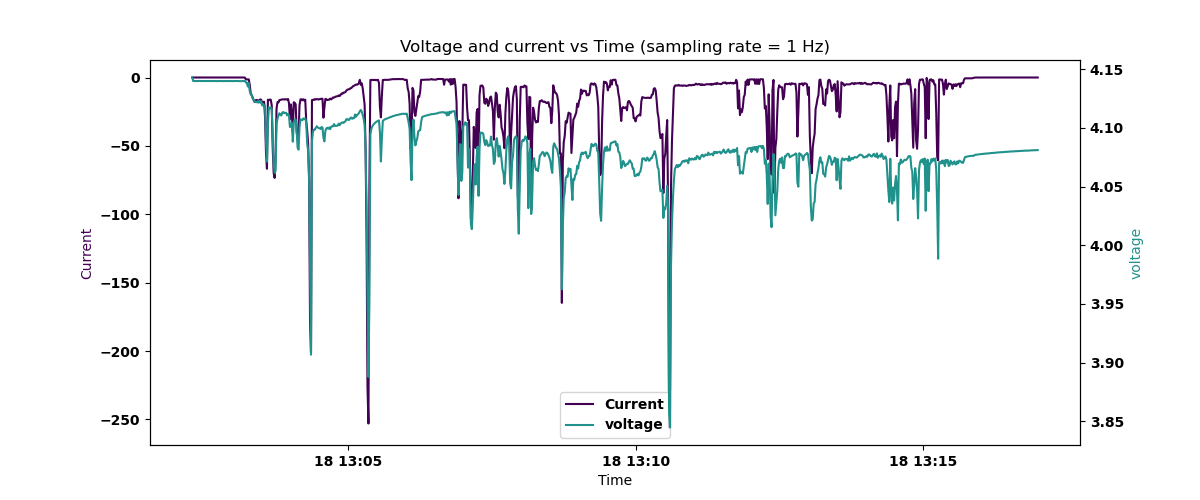

In [98]:
%matplotlib notebook
# 1. Show both values vs time
fig_path = os.path.join(cwd, 'figures')
plot_path = os.path.join(fig_path, 'volt_follows_cur.pdf')

for df_each in li_train_cycles:
    df_temp = df_each.copy()
    custom_plot.plot_dual_axis_new(("Voltage and current vs Time (sampling rate = 1 Hz)", plot_path), (df_temp['timestamp'], "Time"), (df_temp['current'], "Current"), (df_temp['V'], "voltage"))
    df_temp = np.nan
    break

#### Pearson's correlation efficient
Pearson correlation coefficient is a measure of linear correlation between two sets of data. It is the ratio between the covariance of two variables and the product of their standard deviations; thus it is essentially a normalized measurement of the covariance, such that the result always has a value between −1 and 1. It only reflects a linear correlation of variables, and ignores many other types of relationship or correlation. 

<IPython.core.display.Javascript object>


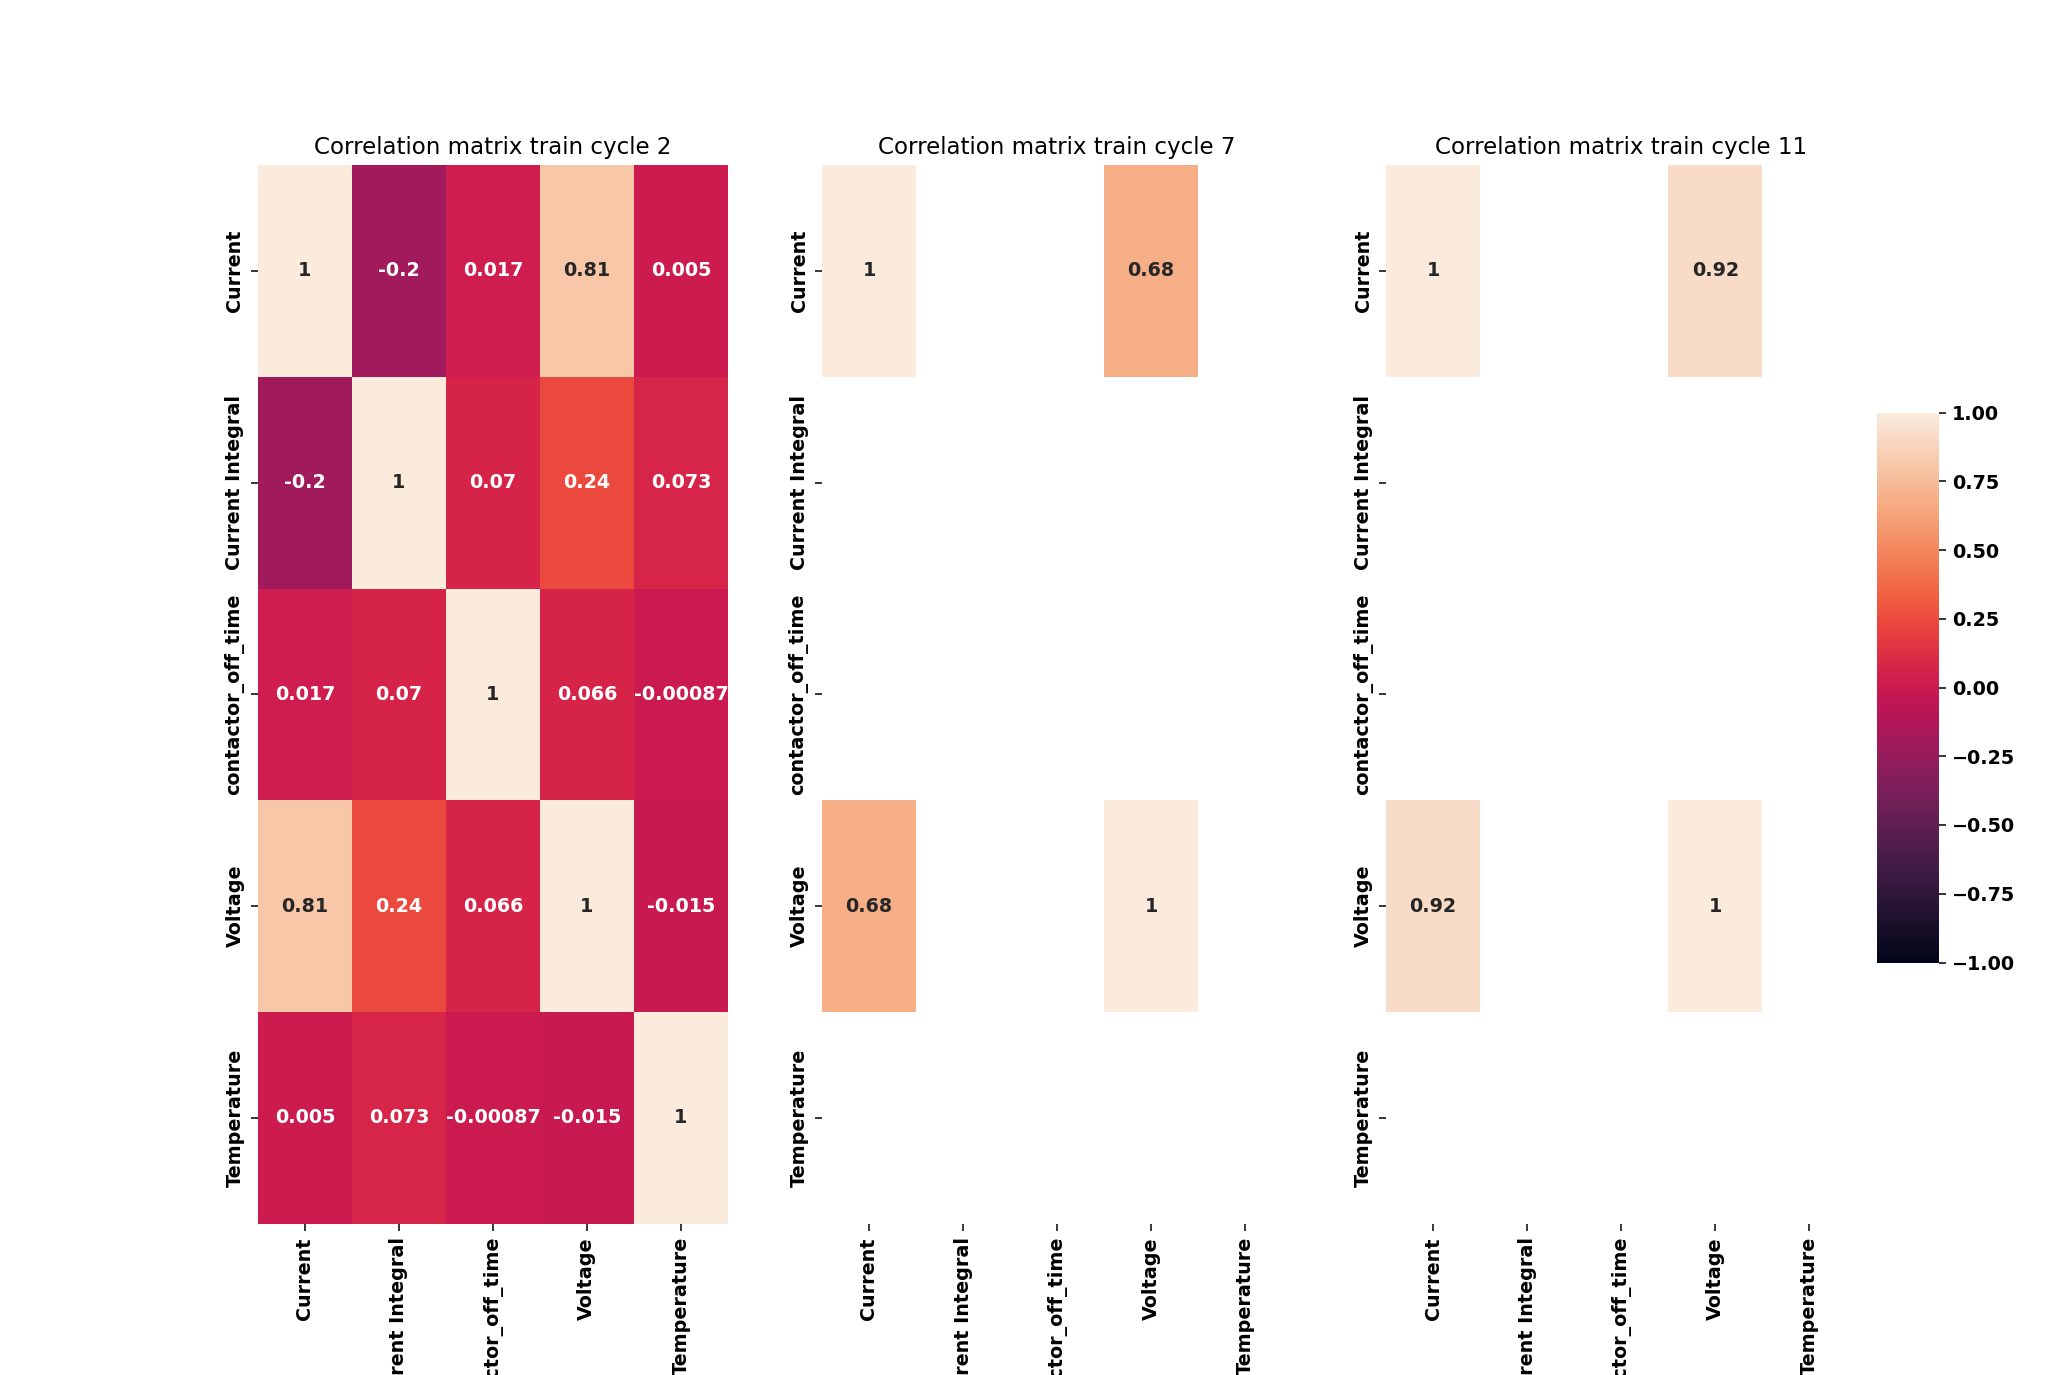

In [159]:
%matplotlib notebook
# 2. Take random train cycles and show correlation between current and voltage
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr

random.seed(100)           # seed for regenerating, any number for seed
li_random_cells = random.sample(range(len(li_train_cycles)), 3)    # randomly pick 3 battery cells

# set save path for plot
fig_path = os.path.join(cwd, 'figures')
plot_path = os.path.join(fig_path, 'correlation_matrix_heatmap.pdf')

cols = 3
rows = 1
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])           # color bar

for i, ax in enumerate(axes.flat):       # will run 3 times
    cycle_id = li_random_cells[i]
    df_temp = li_train_cycles[cycle_id].copy()
    df_temp = df_temp[['current', 'cur_integral_module1', 'contactor_off_time', 'V', 'Temp']]           # keep relevant columns
    df_temp.rename(columns = {'current':'Current', 'V':'Voltage', 'cur_integral_module1':'Current Integral', 'Temp': 'Temperature'}, inplace = True)               # rename some columns for better readability
    Var_Corr = df_temp.corr()
    ax.set_title('Correlation matrix train cycle ' + str(cycle_id))
    sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True, ax=ax, vmin=-1, vmax=1, cbar_ax=cbar_ax)     #  cbar_ax=cbar_ax

plt.show()
plt.savefig(plot_path)
# comment: gaps come from NAN values, usually it thappens when SD is NAN

#### AutoCorrelation Function and Partial Autocorrelation Function for understanding time series data
https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/#:~:text=Autocorrelation%20is%20the%20correlation%20between,values%20influence%20the%20current%20value.
1. Autocorrelation is the correlation between two observations at different points in a time series.
2.  Use the autocorrelation function (ACF) to identify which lags have significant correlations, understand the patterns and properties of the time series, and then use that information to model the time series data. In an ACF plot, each bar represents the size and direction of the correlation. Bars that extend across the red line are statistically significant.
3. The partial autocorrelation function is similar to the ACF except that it displays only the correlation between two observations that the shorter lags between those observations do not explain.
4.

In [36]:
%matplotlib notebook
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics import tsaplots

# 3. Show autocorrelation of voltage (based on lag, third plot below)
# ACF and PCF don't have meaning in the non-stationary case.
# Autocor with current and voltage

# For the same random cycles, draw ACF and PACF

# for i in range(len(li_random_cells)):
#     cycle_id = li_random_cells[i]
#     print(cycle_id)
#     df_temp = li_train_cycles[cycle_id].copy()
#     df_temp['diff'] = df_temp['V'] - df_temp['V'].shift(1)
#     df_temp['diff'].plot()
#     tsaplots.plot_acf(df_temp['diff'].dropna(),lags =20)
#     tsaplots.plot_pacf(df_temp['diff'].dropna(),lags =1)

<IPython.core.display.Javascript object>


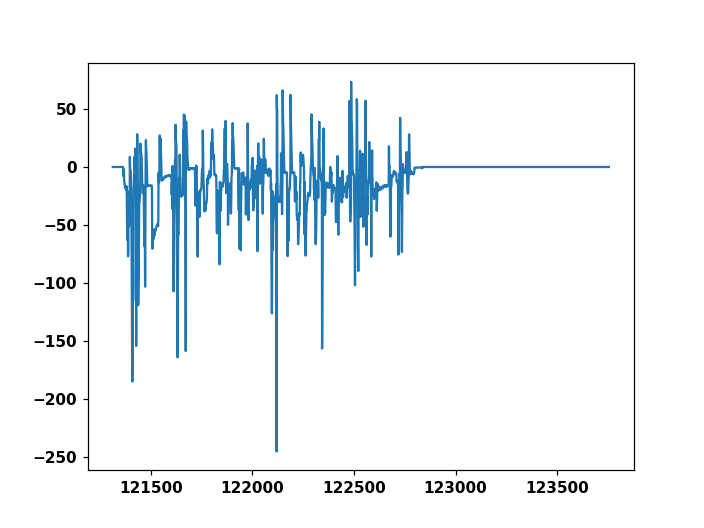

In [60]:
%matplotlib notebook
# len(li_train_cycles[4])
# Drive cycles: 1, 2, 3, 4, 5, 7, 9, 11
# Save all drive cycles to list
li_drive_cycles = [
    li_train_cycles[1],
    li_train_cycles[2],
    li_train_cycles[3],
    li_train_cycles[4],
    li_train_cycles[5],
    li_train_cycles[7],
    li_train_cycles[9],
    li_train_cycles[11]
    ]

dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'li_drive_cycles.pkl')
with open(src_path, 'wb') as f:
    pickle.dump(li_drive_cycles, f)

df = li_train_cycles[4]['current'].plot()
# df1 = 

### Experiment: Train on a single cycle and evaluate


In [153]:
# Make multivariate dataset ready for LSTM
# [temporal input sequence] [output]


# example:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_supervised_multivariate(df_as_np, input_window, label_index, output_window=1):
    X = []
    y = []
    for i in range(len(df_as_np) - input_window):
        X.append(df_as_np[i:i+input_window, 0:df_as_np.shape[1]])
#         print(df_as_np[i:i+input_window, 0:df_as_np.shape[1]])
        label = df_as_np[i+input_window][label_index]    # index of output label ie voltage
        y.append(label)
    
    return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 10

X, y = df_to_supervised_multivariate(df_multivar_train_scaled.to_numpy(), WINDOW_SIZE, 1)     # prepare sequences for each cycle

In [17]:
# Make dataset ready for LSTM
# [temporal input sequence] [output]
# example:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_supervised_univariate(df_feature, df_label, window_size=5):
    df_feature_as_np = df_feature.to_numpy()
    df_label_as_np = df_label.to_numpy()
    X = []
    y = []
    total_rows = len(df_feature_as_np) - window_size + 1
    for i in range(len(df_feature_as_np) - window_size):
        row = [[a] for a in df_feature_as_np[i:i+window_size]]
        X.append(row)
        label = df_label_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

### Multiple parallel
1. Each batch contains one static-> dynamic -> static cycle
2. Uses default validation data from keras, no manual validation is used
3. Experiment done on one cell cycles


In [18]:
# no scaling, make sequence windows for train and test
WINDOW_SIZE = 10

train_seq = list()
val_seq = list()
test_seq = list()

for df in li_train_cycles:
    df_each_cycle = df.copy()
    X, y = df_to_supervised_univariate(df_each_cycle['current'], df_each_cycle['V'], WINDOW_SIZE)     # prepare sequences for each cycle
    train_seq.append((X,y))

# for df in li_validation_cycles:
#     df_each_cycle = df.copy()
#     X, y = df_to_supervised_univariate(df_each_cycle['current'], df_each_cycle['V'], WINDOW_SIZE)     # prepare sequences for each cycle
#     val_seq.append((X,y))
    
for df in li_test_cycles:
    df_each_cycle = df.copy()
    X, y = df_to_supervised_univariate(df_each_cycle['current'], df_each_cycle['V'], WINDOW_SIZE)     # prepare sequences for each cycle
    test_seq.append((X,y))

print(len(train_seq), len(val_seq), len(test_seq))

15 0 2


In [28]:
x_train = li_train_cycles[0]

# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.fit_transform(x_test)

down_sample = True
if down_sample:
    val_args = np.arange(len(x_train))[::5]
    x_val = x_train[val_args]
    y_val = y[val_args]
    x_train = np.delete(x_train, val_args, axis=0)
    y_train = np.delete(y, val_args, axis=0)


timestamp  current  min_SOC  contactor_state       V  Temp  \
4016023 2022-03-02 17:58:44      0.0    73.30              0.0  3.8543  13.0   
4016024 2022-03-02 17:58:45      0.0    73.30              0.0  3.8543  13.0   
4016025 2022-03-02 17:58:46      0.0    73.30              0.0  3.8543  13.0   
4016026 2022-03-02 17:58:47      0.0    73.30              0.0  3.8543  13.0   
4016027 2022-03-02 17:58:48      0.0    73.74              0.0  3.8562  12.0   
...                     ...      ...      ...              ...     ...   ...   
4016149 2022-03-02 18:00:50      0.0    73.58              0.0  3.8515  12.0   
4016150 2022-03-02 18:00:51      0.0    73.58              0.0  3.8516  12.0   
4016151 2022-03-02 18:00:52      0.0    73.58              0.0  3.8516  12.0   
4016152 2022-03-02 18:00:53      0.0    73.58              0.0  3.8517  12.0   
4016153 2022-03-02 18:00:54      0.0    73.58              0.0  3.8517  12.0   

         elapsed_sec  
4016023          0.0  
4016024          1.0  
4016025          2.0  
4016026          3.0  
4016027          4.0  
...              ...  
4016149        126.0  
4016150        127.0  
4016151        128.0  
4016152        129.0  
4016153        130.0  

[131 rows x 7 columns]

In [31]:
a=np.arange(0,100,1)
# a
val_args = np.arange(len(a))[::5]
x_val = a[val_args]
print(x_val)

[ 0  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]


### Train-vali:
In order to avoid bias from exposure to a particular time/portion of the drive cycle, the train and val data has to be split in a specia manner. Both train and val data must be taken from complete range of drive cycle

#### Terminology:
1. Epochs: one epoch: one pass over the entire dataset. Epochs means how many times the algorithm goes through the training dataset
2. callbacks: A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).<br>
    2.1. Early stopping: If the result does not improve (error does not minimize after n epochs), then use early stopping so that all epochs are not necessary to run<br>
    2.2. model checkpoint: Periodically save your model to disk<br>
    2.3. Tensorboard logs: Write TensorBoard logs after every batch of training to monitor your metrics <br>

In [19]:
# import ML related APIs

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_12132\1923026697.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


#### Train, validation and test data
1. All static_dynamic_static cycles of a cell are divided into train and test (unseen by model). The test cycles are intact and will only be used to test model performance for unseen data
2. Each cycle is divided into train and validation data using train_test_split for Keras <br>
    2.1 Keras train_test_split splits data sequentially, e.g., X_train will contain the first $p$ data points, while validation data will be the following $(100-p)$ data points <br>
    2.2. Shuffling will not be used while train/validation split because we need time series (sequential) properties, shuffle will destroy it <br>
    2.3. Because resting voltage happens at the end of each cycle, sequential train-test split can put all the resting voltatge into validation data. So, a 50-50 or 60-40 train-val split will be used, the assumption is that entirety of the validation data does not fall into resting voltage period.

In [90]:
# test
data = np.arange(1, 25).reshape(6, 2, 2)
label = np.array([100, 200, 300, 400, 500, 600])
# print(data, label)
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.40, shuffle=False)
# print('X', X_train, 'y_train:', y_train)


In [91]:
# for seq in train_seq:
#     data, label = seq
#     X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.40, shuffle=False)
#     break

# print('data len', len(data))
# print('X', len(X_train), 'y_train:', len(y_train))
# print('X', X_train, 'y_train:', y_train)

In [20]:
# Use this function for normalization scaling
# li_features contains input variables/features (column names) for the time series
def get_min_max_normalized_df(df, li_features):
    df_result = df.copy()
    for feature in li_features:
        df_result[feature] = (df_result[feature] - df_result[feature].min()) / (df_result[feature].max() - df_result[feature].min())
    return df_result

In [21]:
def univariate_lstm(model_path, log_path, train_seq, window_size = 10):
    from sklearn.model_selection import train_test_split

    # Build LSTM model
    model = Sequential()
    model.add(InputLayer((window_size, 1)))   # each of training input are a window_size * 1 vector
    model.add(LSTM(32))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    # save_best_only=true saves the best model with lowest validation loss
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=2,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(model_path + '/', monitor='val_loss', mode='min', save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir=log_path),
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    for i in range(len(train_seq)):
        print('cycle # ', i+1)
        data, label = train_seq[i]
        x_train, x_val, y_train, y_val = train_test_split(data, label, test_size=0.40, shuffle=False)
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=1, verbose=2, callbacks=my_callbacks, shuffle=False)
        model.reset_states()         # reset state at the end of each cycle because the new cycle is a new time series
    return history

In [17]:
# Save history for plotting later
import pickle
dir_path = os.path.join(cwd, 'lstm_univar_window10')
src_path = os.path.join(dir_path, 'univariate_history.pkl')

with open(src_path, 'wb') as f:
    pickle.dump(history.history, f)
print(history.history)

{'loss': [0.0062392293475568295, 0.0022954214364290237, 0.0014403178356587887, 0.0011351595167070627, 0.0009733702172525227, 0.0008805316174402833, 0.0008743185317143798, 0.0008149578352458775, 0.0008159750723280013], 'root_mean_squared_error': [0.07898879051208496, 0.04791055619716644, 0.0379515178501606, 0.0336921289563179, 0.031198881566524506, 0.029673753306269646, 0.029568877071142197, 0.028547465801239014, 0.02856527827680111], 'val_loss': [0.0018881304422393441, 0.0014599611749872565, 0.001035884371958673, 0.0009423292358405888, 0.000976757612079382, 0.0009382694261148572, 0.0010264707962051034, 0.0010596258798614144, 0.0013779709115624428], 'val_root_mean_squared_error': [0.04345262423157692, 0.03820943832397461, 0.032185155898332596, 0.030697381123900414, 0.03125312179327011, 0.030631184577941895, 0.03203858435153961, 0.03255189582705498, 0.03712103143334389]}


In [9]:
# Plot train vs val loss
import pickle
# load last saved df and convert time stamp and sort
dir_path = os.path.join(cwd, 'lstm_univar_window10')
src_path = os.path.join(dir_path, 'univariate_history.pkl')

with open(src_path, 'rb') as f:
    dict_history = pickle.load(f)

<IPython.core.display.Javascript object>


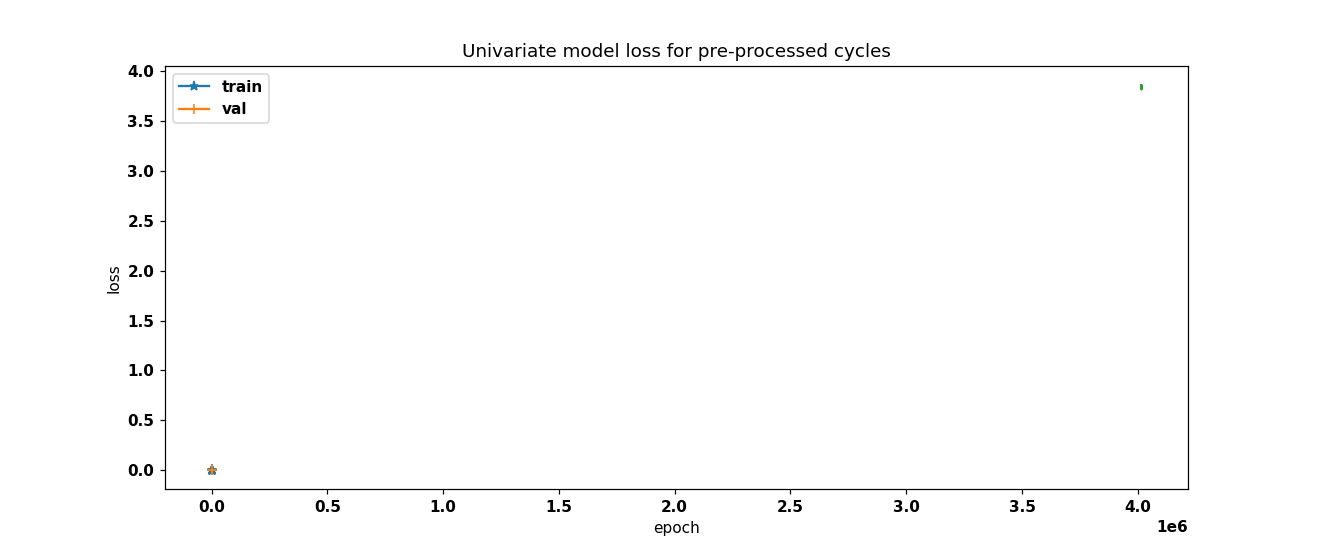

In [11]:
# Plot history (train, val loss vs epochs)

dir_path = os.path.join(cwd, 'lstm_univar_window10')
src_path = os.path.join(dir_path, 'univariate_loss.pdf')

import matplotlib
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 10}

matplotlib.rc('font', **font)
fig = plt.figure(figsize =(12 ,5))

plt.plot(dict_history['loss'], marker='*')
plt.plot(dict_history['val_loss'], marker='+')
plt.title('Univariate model loss for pre-processed cycles')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
fig.savefig(src_path)

In [108]:
# load trianed univariate model
from keras.models import load_model
from keras.utils.vis_utils import plot_model

model = load_model('lstm_univar_window10/model.04-0.00.h5')      # load epoch 4 since train and val loss converges there

plot_model(model, to_file='lstm_univar_window10/univariate_model_plot.pdf', show_shapes=True, show_layer_names=True, dpi=120)

In [104]:
# Assumes input X and y are already scaled
def pred_rmse(model, X, y, start=0, end=1000, plot_path=''):

#     if (do_scaling):
#         scaled_X = get_min_max_normalized_df(X, ['current'])
#         yhat = model.predict(scaled_X)
#     else:
#         yhat = model.predict(X)    #shape = (n, 1) where n= X.shape[0] eg number of total data points

    yhat = model.predict(X)    #shape = (n, 1) where n= X.shape[0] eg number of total data points
    yhat = yhat.flatten()
    df = pd.DataFrame(data={'Predictions':yhat, 'Actuals':y})
    df_temp = pd.DataFrame()
    df_temp['counter'] = range(len(y))   # x axis for plot

    rmse = mean_squared_error(y, yhat, squared=False)
    mse = mean_squared_error(y, yhat)
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    str_rmse = "{:.3f}".format(rmse)
    str_mae = "{:.3f}".format(mae)
    print('plot_rmse', str_rmse)
    custom_plot.plot_multi_line(('Predicted vs Actual voltage (RMSE=' + str_rmse + ', MAE: ' + str_mae + ')', plot_path, "Voltage (V)"), (df_temp['counter'], custom_plot.ELAPSED_TIME), (df['Actuals'], "Actual voltage"), (df['Predictions'][start:end], "Predicted voltage"))
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("MAPE: ", mape)
    return df_temp, rmse

labels 403
plot_rmse 0.025


<IPython.core.display.Javascript object>


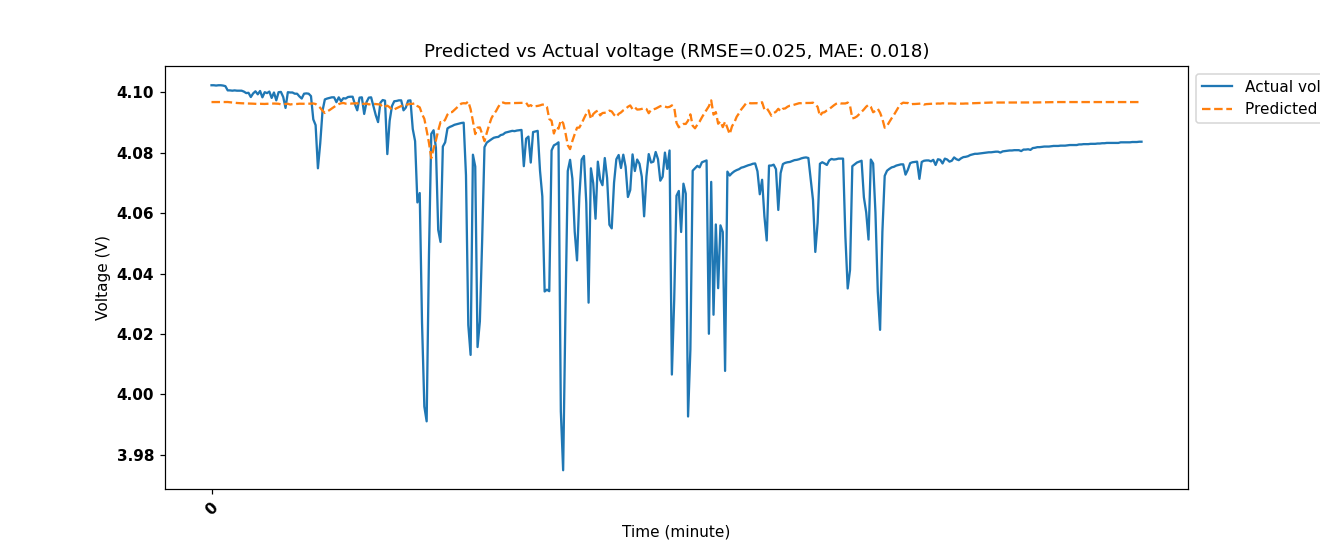

MSE:  0.0006453085786319625
RMSE:  0.025402924607847075
MAE:  0.018303637498424917
MAPE:  0.004509690937773535


In [109]:
x_test, y_test =test_seq[1]
print('labels', y_test.shape[0])
fig_path = os.path.join(cwd, 'lstm_univar_window10')
plot_path = os.path.join(fig_path, 'predicted_vs_actual_volt.pdf')
# Evaluate model
df_yhat, rmse = pred_rmse(model, x_test, y_test, 0, y_test.shape[0], plot_path)  # prediction on test data

#### Evaluation remarks
Because every cycle can be different in nature, e.g., drive cycle, drive cycle followed by charge cycle, charge cycle, short time-span cycle, long-span cycle etc., it is hard for the model to generalize if not trained with a high variety of data

In [64]:
%load_ext tensorboard
logs_base_dir = os.path.join(cwd, 'logs')
print(logs_base_dir)
# monitor logs from tensor board
%tensorboard --logdir {logs_base_dir}


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
C:\Users\s.kaiser\Experiments\MuleCarData\logs\fit


In [ ]:
# Rolling forecast:

## Experiment 2: same as experiment 1 with scaled input (voltage) data

In [22]:
# Scale train and test cycles input currents
WINDOW_SIZE = 10

train_seq = list()
val_seq = list()
test_seq = list()

li_train_scaled = []
li_test_scaled = []

for df in li_train_cycles:
    df_each_cycle = df.copy()
    df_scaled_train = get_min_max_normalized_df(df_each_cycle, ['current'])
    li_train_scaled.append(df_scaled_train)
    
for df in li_train_scaled:
    df_each_cycle = df.copy()
    X, y = df_to_supervised_univariate(df_each_cycle['current'], df_each_cycle['V'], WINDOW_SIZE)     # prepare sequences for each cycle
    train_seq.append((X,y))
    
for df in li_test_cycles:
    df_each_cycle = df.copy()
    df_scaled_test = get_min_max_normalized_df(df_each_cycle, ['current'])
    li_test_scaled.append(df_scaled_test)

for df in li_test_scaled:
    df_each_cycle = df.copy()
    X, y = df_to_supervised_univariate(df_each_cycle['current'], df_each_cycle['V'], WINDOW_SIZE)     # prepare sequences for each cycle
    test_seq.append((X,y))

print(len(train_seq), len(test_seq))

15 2


In [24]:
li_test_scaled[0]

timestamp   current  min_SOC  cur_integral_module1  \
588604 2022-03-04 11:10:03  0.953468    98.05               18300.0   
588605 2022-03-04 11:10:04  0.953468    98.05               18300.0   
588606 2022-03-04 11:10:05  0.953468    98.03               18300.0   
588607 2022-03-04 11:10:06  0.953468    98.03               18300.0   
588608 2022-03-04 11:10:07  0.953468    98.03               18300.0   
...                    ...       ...      ...                   ...   
589089 2022-03-04 11:18:08  0.953468    97.00               18300.0   
589090 2022-03-04 11:18:09  0.953468    97.00               18300.0   
589091 2022-03-04 11:18:10  0.953468    97.00               18300.0   
589092 2022-03-04 11:18:11  0.953468    97.00               18300.0   
589093 2022-03-04 11:18:12  0.953468    97.00               18300.0   

        contactor_state  contactor_off_time       V  Temp  elapsed_sec  
588604              0.0                 0.0  4.1169  8.75          0.0  
588605              0.0                 0.0  4.1169  8.75          1.0  
588606              0.0                 0.0  4.1168  8.75          2.0  
588607              0.0                 0.0  4.1168  8.75          3.0  
588608              0.0                 0.0  4.1167  8.75          4.0  
...                 ...                 ...     ...   ...          ...  
589089              0.0                 0.0  4.0995  8.75        485.0  
589090              0.0                 0.0  4.0996  8.75        486.0  
589091              0.0                 0.0  4.0996  8.75        487.0  
589092              0.0                 0.0  4.0997  8.75        488.0  
589093              0.0                 0.0  4.0997  8.75        489.0  

[490 rows x 9 columns]

In [25]:
# downsample
print(train_seq)
scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        down_sample = True
        if down_sample:
            val_args = np.arange(len(x_train))[::5]
            x_val = x_train[val_args]
            y_val = y[val_args]
            x_train = np.delete(x_train, val_args, axis=0)
            y_train = np.delete(y, val_args, axis=0)


[(array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]]), array([3.8562, 3.8562, 3.8562, 3.8562, 3.8562, 3.8562, 3.8547, 3.8542,
       3.8512, 3.8539, 3.8404, 3.8357, 3.8387, 3.837 , 3.8412, 3.8363,
       3.8353, 3.8342, 3.8343, 3.8236, 3.8238, 3.8333, 3.8363, 3.8326,
       3.8202, 3.8148, 3.8368, 3.8313, 3.8163, 3.8297, 3.829 , 3.8297,
       3.8274, 3.8309, 3.8288, 3.828 , 3.8302, 3.8326, 3.8352, 3.8374,
       3.8369, 3.8382, 3.8394, 3.84

In [23]:
# Scale 
model_path = os.path.join(cwd, 'lstm_univar_window10_scaled')
log_path = os.path.join(cwd, 'lstm_univar_window10_scaled', 'logs')

history = univariate_lstm(model_path, log_path, train_seq, 10)
print(history)

NameError: name 'InputLayer' is not defined

<IPython.core.display.Javascript object>


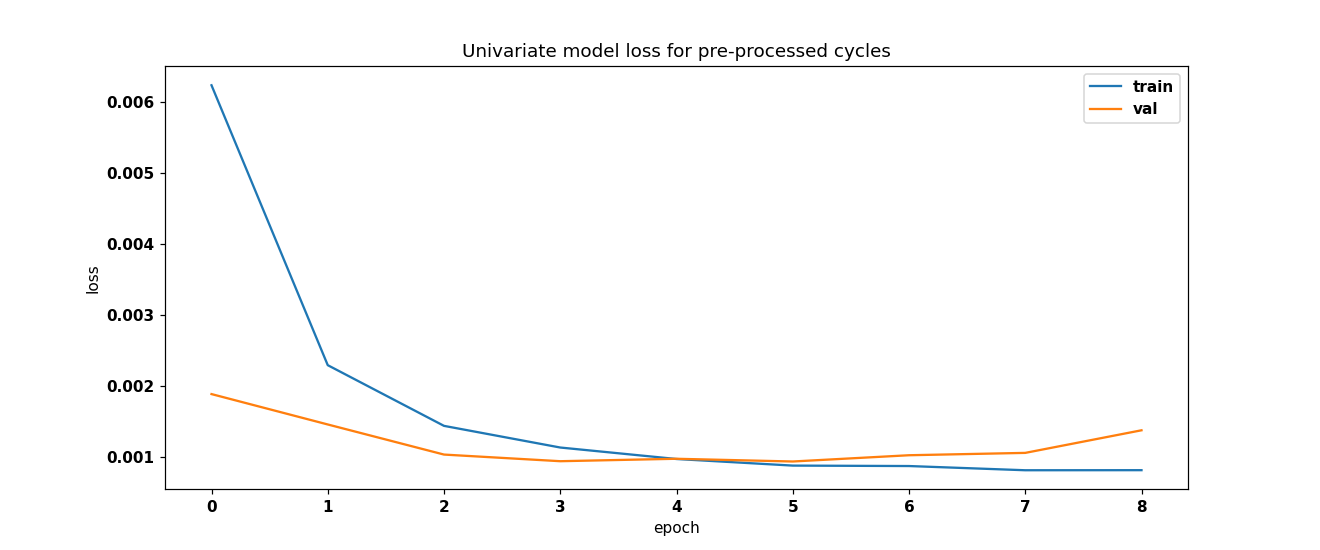

In [84]:
history

# Plot history (train, val loss vs epochs)

dir_path = os.path.join(cwd, 'lstm_univar_window10_scaled')
src_path = os.path.join(dir_path, 'loss_train_vs_val.pdf')

import matplotlib
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 10}

matplotlib.rc('font', **font)
fig = plt.figure(figsize =(12 ,5))

plt.plot(dict_history['loss'])
plt.plot(dict_history['val_loss'])
plt.title('Univariate model loss for pre-processed cycles')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
fig.savefig(src_path)

plot_rmse 0.029


<IPython.core.display.Javascript object>


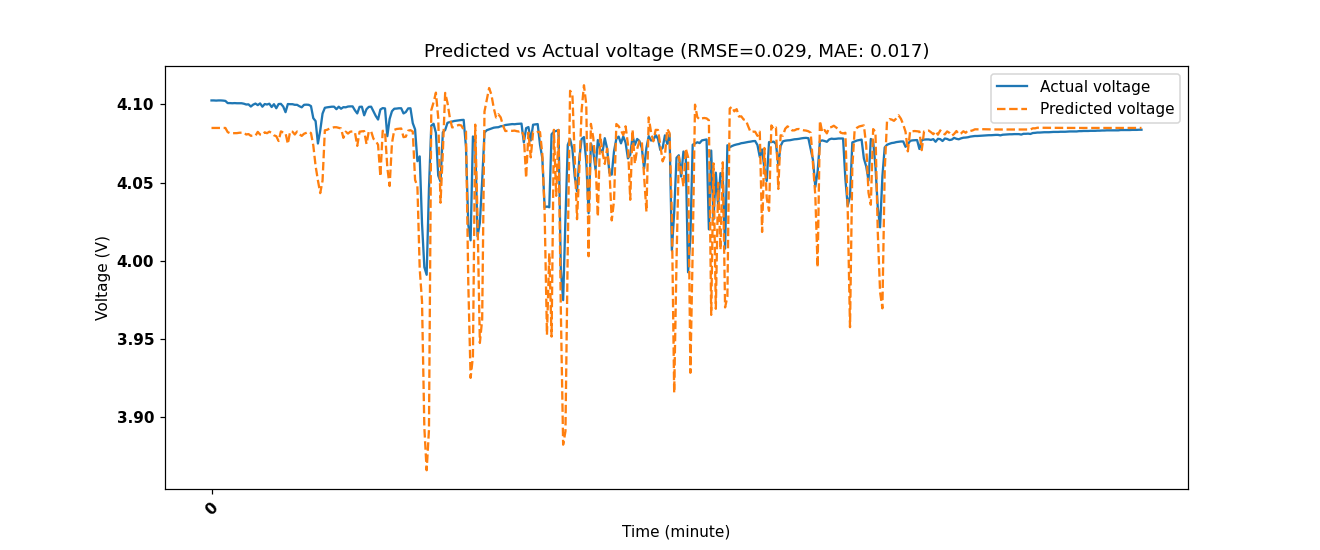

MSE:  0.0008133265153309132
RMSE:  0.028518879980302753
MAE:  0.0167818350401469
MAPE:  0.004128498279752977


In [107]:
# load trianed univariate model
from keras.models import load_model
from keras.utils.vis_utils import plot_model

model = load_model('lstm_univar_window10_scaled/')      # load saved model

fig_path = os.path.join(cwd, 'lstm_univar_window10_scaled')
plot_path = os.path.join(fig_path, 'predicted_vs_actual_volt_scaled.pdf')

x_test, y_test =test_seq[1]
df_yhat, rmse = pred_rmse(model, x_test, y_test, 0, y_test.shape[0], plot_path)  # prediction on test data

## Experiment 3: Solve overfitting from from the previous experiments
**Things to consider** 
1. Stacked LSTM (increased depth for richer features such as temporal properties) 
2. More neurons (increased width for more features)
3. Recurrent dropout to overcome overfitting
4. Avoid cycle preprocessing and take time-divided normal cycles
5. Make train-val split as 80-20
6. Experiment with stateful=True, this ensures BPTT considers each cycle as one unit even though they are divided into sequence windows i.e., time steps
7. Make time series stationary (logarithm)
8. Padding data
9. L1 and L2 regularization techniques to overcome overfitting
10. Experimient data smoothing such as moving average
11. Change loss function from RMSE to MSE

In [166]:
def univariate_lstm_neurons_dropout(model_path, log_path, train_seq, window_size = 10, num_neurons=64, dropout=0.2):
    from sklearn.model_selection import train_test_split

    # Build LSTM model
    model = Sequential()
    model.add(InputLayer((window_size, 1)))   # each of training input are a window_size * 1 vector
    model.add(LSTM(num_neurons, recurrent_dropout=dropout))
#     model.add(LSTM(n_neurons, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    # save_best_only=true saves the best model with lowest validation loss
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=2,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(model_path + '/', monitor='val_loss', mode='min', save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir=log_path),
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    for i in range(len(train_seq)):
        print('cycle # ', i+1)
        data, label = train_seq[i]
        x_train, x_val, y_train, y_val = train_test_split(data, label, test_size=0.20, shuffle=False)       # 80-20 split
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=1, verbose=2, callbacks=my_callbacks, shuffle=False)
#         model.reset_states()         # reset state at the end of each cycle because the new cycle is a new time series
    return history

In [167]:
# No scaling for univariate analysis, like Experiment 1
# print(len(train_seq), len(val_seq), len(test_seq))

model_path = os.path.join(cwd, 'univariate_lstm_neurons_dropout_win10')
log_path = os.path.join(cwd, 'univariate_lstm_neurons_dropout_win10', 'logs')

# train model
history = univariate_lstm_neurons_dropout(model_path, log_path, train_seq, 10, 64, 0.2)
print(history)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________
cycle #  1
Epoch 1/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


96/96 - 4s - loss: 11.3162 - root_mean_squared_error: 3.3640 - val_loss: 13.9474 - val_root_mean_squared_error: 3.7346 - 4s/epoch - 46ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


96/96 - 3s - loss: 8.9712 - root_mean_squared_error: 2.9952 - val_loss: 12.6447 - val_root_mean_squared_error: 3.5559 - 3s/epoch - 33ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


96/96 - 3s - loss: 6.6557 - root_mean_squared_error: 2.5799 - val_loss: 9.7394 - val_root_mean_squared_error: 3.1208 - 3s/epoch - 29ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


96/96 - 3s - loss: 3.4578 - root_mean_squared_error: 1.8595 - val_loss: 2.5015 - val_root_mean_squared_error: 1.5816 - 3s/epoch - 28ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


96/96 - 3s - loss: 0.6764 - root_mean_squared_error: 0.8225 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086 - 3s/epoch - 32ms/step
Epoch 6/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


96/96 - 3s - loss: 0.2960 - root_mean_squared_error: 0.5441 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574 - 3s/epoch - 32ms/step
Epoch 7/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


96/96 - 3s - loss: 0.2097 - root_mean_squared_error: 0.4580 - val_loss: 4.4612e-04 - val_root_mean_squared_error: 0.0211 - 3s/epoch - 35ms/step
Epoch 8/10
96/96 - 0s - loss: 0.1436 - root_mean_squared_error: 0.3789 - val_loss: 7.4296e-04 - val_root_mean_squared_error: 0.0273 - 464ms/epoch - 5ms/step
Epoch 9/10
96/96 - 0s - loss: 0.0948 - root_mean_squared_error: 0.3079 - val_loss: 4.8641e-04 - val_root_mean_squared_error: 0.0221 - 487ms/epoch - 5ms/step
Epoch 10/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


96/96 - 3s - loss: 0.0759 - root_mean_squared_error: 0.2756 - val_loss: 1.3486e-04 - val_root_mean_squared_error: 0.0116 - 3s/epoch - 36ms/step
cycle #  2
Epoch 1/10
699/699 - 5s - loss: 0.0406 - root_mean_squared_error: 0.2016 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1607 - 5s/epoch - 7ms/step
Epoch 2/10
699/699 - 5s - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059 - 5s/epoch - 8ms/step
Epoch 3/10
699/699 - 5s - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858 - 5s/epoch - 7ms/step
Epoch 4/10
699/699 - 5s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824 - 5s/epoch - 7ms/step
Epoch 5/10
699/699 - 5s - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0664 - 5s/epoch - 7ms/step
Epoch 6/10
699/699 - 5s - loss: 0.0046 - root_mean_squared_error: 0.0680 - val_loss: 

INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


822/822 - 10s - loss: 2.3795e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.3282e-05 - val_root_mean_squared_error: 0.0058 - 10s/epoch - 12ms/step
Epoch 4/10
822/822 - 6s - loss: 2.4155e-04 - root_mean_squared_error: 0.0155 - val_loss: 2.1227e-04 - val_root_mean_squared_error: 0.0146 - 6s/epoch - 7ms/step
Epoch 5/10
822/822 - 6s - loss: 2.3692e-04 - root_mean_squared_error: 0.0154 - val_loss: 6.0699e-05 - val_root_mean_squared_error: 0.0078 - 6s/epoch - 7ms/step
Epoch 6/10
822/822 - 5s - loss: 2.3365e-04 - root_mean_squared_error: 0.0153 - val_loss: 7.1163e-05 - val_root_mean_squared_error: 0.0084 - 5s/epoch - 6ms/step
Epoch 6: early stopping
cycle #  6
Epoch 1/10
985/985 - 6s - loss: 8.7115e-05 - root_mean_squared_error: 0.0093 - val_loss: 4.0044e-04 - val_root_mean_squared_error: 0.0200 - 6s/epoch - 6ms/step
Epoch 2/10
985/985 - 6s - loss: 7.0931e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.2318e-04 - val_root_mean_squared_error: 0.0111 - 6s/epoch - 6ms/step
Epoch 3/10
98

INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univariate_lstm_neurons_dropout_win10\assets


1945/1945 - 16s - loss: 0.0021 - root_mean_squared_error: 0.0453 - val_loss: 4.4943e-08 - val_root_mean_squared_error: 2.1200e-04 - 16s/epoch - 8ms/step
Epoch 2/10
1945/1945 - 13s - loss: 6.9182e-04 - root_mean_squared_error: 0.0263 - val_loss: 8.7616e-06 - val_root_mean_squared_error: 0.0030 - 13s/epoch - 7ms/step
Epoch 3/10
1945/1945 - 13s - loss: 7.0494e-04 - root_mean_squared_error: 0.0266 - val_loss: 4.7829e-05 - val_root_mean_squared_error: 0.0069 - 13s/epoch - 7ms/step
Epoch 4/10
1945/1945 - 11s - loss: 8.2184e-04 - root_mean_squared_error: 0.0287 - val_loss: 2.8081e-05 - val_root_mean_squared_error: 0.0053 - 11s/epoch - 6ms/step
Epoch 4: early stopping
cycle #  8
Epoch 1/10
1116/1116 - 8s - loss: 8.4642e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068 - 8s/epoch - 7ms/step
Epoch 2/10
1116/1116 - 8s - loss: 9.2906e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758 - 8s/epoch - 7ms/step
Epoc

Epoch 6/10
1666/1666 - 10s - loss: 6.4752e-04 - root_mean_squared_error: 0.0254 - val_loss: 1.9026e-04 - val_root_mean_squared_error: 0.0138 - 10s/epoch - 6ms/step
Epoch 7/10
1666/1666 - 9s - loss: 7.0847e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501 - 9s/epoch - 5ms/step
Epoch 7: early stopping


In [168]:
# Save history for plotting later
import pickle
dir_path = os.path.join(cwd, 'univariate_lstm_neurons_dropout_win10')
src_path = os.path.join(dir_path, 'univariate_lstm_neurons_dropout_win10_history.pkl')

with open(src_path, 'wb') as f:
    pickle.dump(history.history, f)
print(history.history)

{'loss': [0.003562629222869873, 0.0011043193517252803, 0.0009139202884398401, 0.0007425515213981271, 0.0006307216826826334, 0.0006475193076767027, 0.0007084662211127579], 'root_mean_squared_error': [0.05968776345252991, 0.03323129937052727, 0.030231114476919174, 0.02724979817867279, 0.02511417306959629, 0.025446400046348572, 0.026617029681801796], 'val_loss': [0.001076438813470304, 0.0005461426335386932, 0.0007098643109202385, 0.0001740223669912666, 0.00036321766674518585, 0.00019025828805752099, 0.0025143628008663654], 'val_root_mean_squared_error': [0.03280912712216377, 0.023369694128632545, 0.02664327807724476, 0.01319175399839878, 0.019058270379900932, 0.01379341445863247, 0.050143420696258545]}


In [169]:
# Plot train vs val loss
import pickle
# load last saved df and convert time stamp and sort
dir_path = os.path.join(cwd, 'univariate_lstm_neurons_dropout_win10')
src_path = os.path.join(dir_path, 'univariate_lstm_neurons_dropout_win10_history.pkl')

with open(src_path, 'rb') as f:
    dict_history = pickle.load(f)

<IPython.core.display.Javascript object>


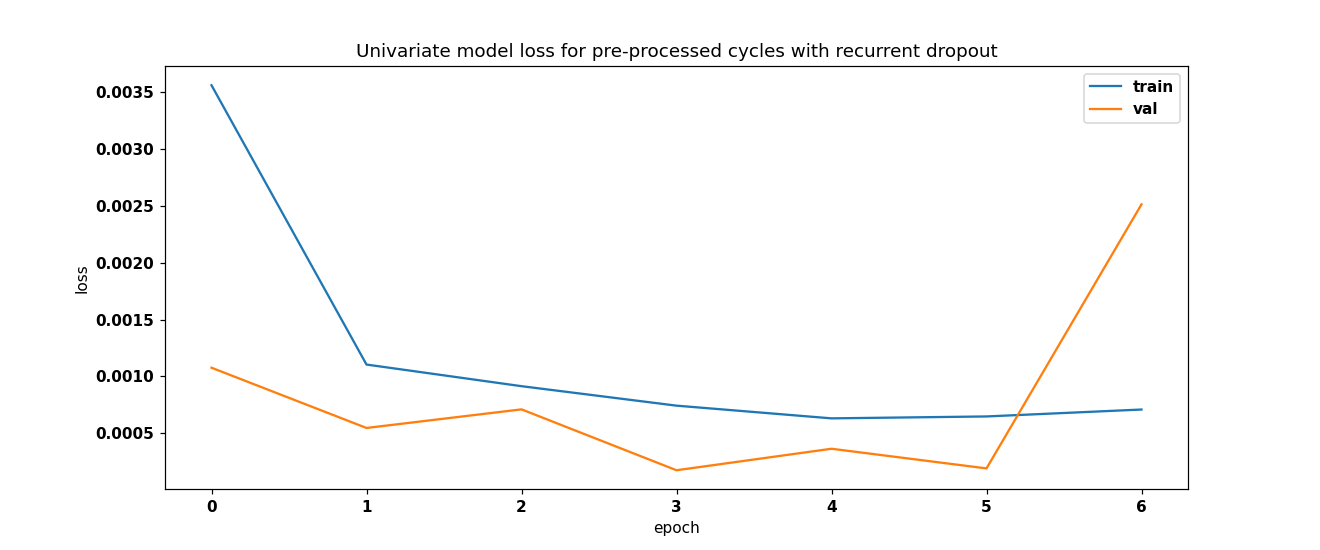

In [171]:
# Plot history (train, val loss vs epochs)

dir_path = os.path.join(cwd, 'univariate_lstm_neurons_dropout_win10')
src_path = os.path.join(dir_path, 'loss_train_vs_val.pdf')

import matplotlib
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 10}

matplotlib.rc('font', **font)
fig = plt.figure(figsize =(12 ,5))

plt.plot(dict_history['loss'])
plt.plot(dict_history['val_loss'])
plt.title('Univariate model loss for pre-processed cycles with recurrent dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
fig.savefig(src_path)

#### comment: using dropout gives worse results
**Reasons for overfitting (above curve)**

1. Your training set had many 'hard' cases to learn
2. Your validation set had mostly 'easy' cases to predict
3. It is important to evaluate model training methodology. If data is not split for training properly, results will lead to confusing, if not simply incorrect, conclusions.

## Experiment 4: experiment 3 still overfits, use multivariate LSTM

In [154]:
# df_multivar_train = df_connected_V1[cols].astype(float)

cols = ['current', 'V', 'Temp']    # input features list: voltage, current, mean temp
train_seq = list()
test_seq = list()

for df in li_train_cycles:
    df_each_cycle = df.copy()
    df_multivar_train = df_each_cycle[cols].astype(float)
    df_multivar_train_scaled = get_min_max_normalized_df(df_multivar_train, cols)
    X, y = df_to_supervised_multivariate(df_multivar_train_scaled.to_numpy(), WINDOW_SIZE, 1)     # prepare sequences for each cycle
    print(X.shape, y.shape)
    train_seq.append((X,y))


for df in li_test_cycles:
    df_multivar_test = df_each_cycle[cols].astype(float)
    df_multivar_test_scaled = get_min_max_normalized_df(df_multivar_test, cols)
    X, y = df_to_supervised_multivariate(df_multivar_test_scaled.to_numpy(), WINDOW_SIZE, 1)     # prepare sequences for each cycle
    print(X.shape, y.shape)
    test_seq.append((X,y))

(121, 10, 3) (121,)
(874, 10, 3) (874,)
(1483, 10, 3) (1483,)
(11868, 10, 3) (11868,)
(1028, 10, 3) (1028,)
(1232, 10, 3) (1232,)
(2432, 10, 3) (2432,)
(1396, 10, 3) (1396,)
(11582, 10, 3) (11582,)
(1729, 10, 3) (1729,)
(5912, 10, 3) (5912,)
(1148, 10, 3) (1148,)
(5692, 10, 3) (5692,)
(121, 10, 3) (121,)
(2083, 10, 3) (2083,)
(2083, 10, 3) (2083,)
(2083, 10, 3) (2083,)


In [156]:
def multivariate_lstm_neurons_dropout(model_path, log_path, train_seq, window_size = 10, num_neurons=64, dropout=0.2, num_features=3):
    from sklearn.model_selection import train_test_split

    # Build LSTM model
    model = Sequential()
    model.add(InputLayer((window_size, num_features)))   # each of training input are a window_size * 3 vector (features: volt, current, temp)
    model.add(LSTM(num_neurons, recurrent_dropout=dropout))
#     model.add(LSTM(n_neurons, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    # save_best_only=true saves the best model with lowest validation loss
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=2,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(model_path + '/', monitor='val_loss', mode='min', save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir=log_path),
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    for i in range(len(train_seq)):
        print('cycle # ', i+1)
        data, label = train_seq[i]
        x_train, x_val, y_train, y_val = train_test_split(data, label, test_size=0.20, shuffle=False)       # 80-20 split
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=1, verbose=2, callbacks=my_callbacks, shuffle=False)
#         model.reset_states()         # reset state at the end of each cycle because the new cycle is a new time series
    return history

In [157]:
# print(len(train_seq), , len(test_seq))

model_path = os.path.join(cwd, 'multivar_lstm_neurons_dropout_win10')
log_path = os.path.join(cwd, 'multivar_lstm_neurons_dropout_win10', 'logs')

# train model
history = multivariate_lstm_neurons_dropout(model_path, log_path, train_seq, 10, 64, 0.2, 3)
print(history)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                17408     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________
cycle #  1
Epoch 1/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\multivar_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\multivar_lstm_neurons_dropout_win10\assets


96/96 - 8s - loss: 0.4940 - root_mean_squared_error: 0.7028 - val_loss: 0.6169 - val_root_mean_squared_error: 0.7854 - 8s/epoch - 82ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\multivar_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\multivar_lstm_neurons_dropout_win10\assets


96/96 - 5s - loss: 0.3424 - root_mean_squared_error: 0.5851 - val_loss: 0.2784 - val_root_mean_squared_error: 0.5276 - 5s/epoch - 54ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\multivar_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\multivar_lstm_neurons_dropout_win10\assets


96/96 - 4s - loss: 0.0443 - root_mean_squared_error: 0.2105 - val_loss: 2.3968e-05 - val_root_mean_squared_error: 0.0049 - 4s/epoch - 43ms/step
Epoch 4/10
96/96 - 1s - loss: 0.0187 - root_mean_squared_error: 0.1368 - val_loss: 2.8527e-05 - val_root_mean_squared_error: 0.0053 - 534ms/epoch - 6ms/step
Epoch 5/10
96/96 - 1s - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 4.8146e-05 - val_root_mean_squared_error: 0.0069 - 587ms/epoch - 6ms/step
Epoch 6/10
96/96 - 1s - loss: 0.0188 - root_mean_squared_error: 0.1372 - val_loss: 5.3528e-05 - val_root_mean_squared_error: 0.0073 - 705ms/epoch - 7ms/step
Epoch 6: early stopping
cycle #  2
Epoch 1/10
699/699 - 6s - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402 - 6s/epoch - 8ms/step
Epoch 2/10
699/699 - 5s - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398 - 5s/epoch - 7ms/step
Epoch 3/10
699/699 - 5s - loss: 0.0068 - root_

INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\multivar_lstm_neurons_dropout_win10\assets


1945/1945 - 15s - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 1.1088e-06 - val_root_mean_squared_error: 0.0011 - 15s/epoch - 8ms/step
Epoch 2/10
1945/1945 - 12s - loss: 0.0030 - root_mean_squared_error: 0.0543 - val_loss: 4.3651e-06 - val_root_mean_squared_error: 0.0021 - 12s/epoch - 6ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\multivar_lstm_neurons_dropout_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\multivar_lstm_neurons_dropout_win10\assets


1945/1945 - 16s - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 9.7503e-07 - val_root_mean_squared_error: 9.8743e-04 - 16s/epoch - 8ms/step
Epoch 4/10
1945/1945 - 13s - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 1.3367e-06 - val_root_mean_squared_error: 0.0012 - 13s/epoch - 6ms/step
Epoch 5/10
1945/1945 - 13s - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 1.2901e-05 - val_root_mean_squared_error: 0.0036 - 13s/epoch - 7ms/step
Epoch 6/10
1945/1945 - 13s - loss: 0.0029 - root_mean_squared_error: 0.0536 - val_loss: 1.4644e-05 - val_root_mean_squared_error: 0.0038 - 13s/epoch - 6ms/step
Epoch 6: early stopping
cycle #  8
Epoch 1/10
1116/1116 - 8s - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan - 8s/epoch - 8ms/step
Epoch 2/10
1116/1116 - 8s - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan - 8s/epoch - 8ms/step
Epoch 3/10
1116/1116 - 9s - loss: nan - root_mea

In [158]:
# Save history for plotting later
import pickle
dir_path = os.path.join(cwd, 'multivar_lstm_neurons_dropout_win10')
src_path = os.path.join(dir_path, 'multivar_lstm_neurons_dropout_win10_history.pkl')

with open(src_path, 'wb') as f:
    pickle.dump(history.history, f)
print(history.history)

{'loss': [nan, nan, nan], 'root_mean_squared_error': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'val_root_mean_squared_error': [nan, nan, nan]}


In [ ]:
# Plot history (train, val loss vs epochs)

dir_path = os.path.join(cwd, 'multivar_lstm_neurons_dropout_win10')
src_path = os.path.join(dir_path, 'loss_train_vs_val.pdf')

import matplotlib
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 10}

matplotlib.rc('font', **font)
fig = plt.figure(figsize =(12 ,5))

plt.plot(dict_history['loss'])
plt.plot(dict_history['val_loss'])
plt.title('Univariate model loss for pre-processed cycles')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
fig.savefig(src_path)

## Experiment 5: Use data without pre-processing

In [175]:
# load unprocessed data for phase 1
import pickle
# load last saved df and convert time stamp and sort
dir_path = os.path.join(cwd, 'csv', 'phase_1_pkl')
src_path = os.path.join(dir_path, 'li_phase1_ts_segments.pkl')

with open(src_path, 'rb') as f:
    li_phase1_ts_segments = pickle.load(f)

In [176]:
# load unprocessed data for phase 2
import pickle
# load last saved df and convert time stamp and sort
dir_path = os.path.join(cwd, 'csv', 'phase_2_pkl')
src_path = os.path.join(dir_path, 'li_segmented_time_series_ph2.pkl')

with open(src_path, 'rb') as f:
    li_phase2_ts_segments = pickle.load(f)

In [183]:
# Extract necessary columns for phase 1 data
li_phase1_dfs = []
for i in range(len(li_phase1_ts_segments)):
    df_each_segment = li_phase1_ts_segments[i].copy()
    df_each_segment = df_each_segment[['timestamp', 'current', 'V1', 'Temp_mean_module1']]
    df_each_segment.rename(columns = {'V1':'V', 'Temp_mean_module1':'Temp'}, inplace = True)
    li_phase1_dfs.append(df_each_segment)

print(li_phase1_dfs[0])

                  timestamp  current       V  Temp
732498  2022-01-15 20:59:16      7.6  4.1014  12.0
732499  2022-01-15 20:59:17      7.6  4.1011  12.0
732500  2022-01-15 20:59:18      7.6  4.1011  12.0
735207  2022-01-15 20:59:19      7.6  4.1012  12.0
735208  2022-01-15 20:59:20      7.7  4.1011  12.0
...                     ...      ...     ...   ...
1030552 2022-01-19 07:01:44     -0.5  4.0136   2.5
1161093 2022-01-19 07:01:45     -0.6  4.0135   2.5
1030554 2022-01-19 07:01:46     -0.5  4.0136   2.5
1161095 2022-01-19 07:01:47     -0.5  4.0136   2.5
1030556 2022-01-19 07:01:48     -0.6  4.0136   2.5

[295353 rows x 4 columns]


In [187]:
# print(li_phase2_ts_segments[0])
# Extract necessary columns for phase 2 data
li_phase2_dfs = []
for i in range(len(li_phase2_ts_segments)):
    df_each_segment = li_phase2_ts_segments[i].copy()
    df_each_segment = df_each_segment[['timestamp', 'current', 'V1', 'Temp_mean']]
    df_each_segment.rename(columns = {'V1':'V', 'Temp_mean_module1':'Temp'}, inplace = True)
    li_phase2_dfs.append(df_each_segment)

print(li_phase2_dfs[0])

                 timestamp  current       V  Temp_mean
758365 2021-11-11 18:30:45     -0.5  3.7714      15.00
758366 2021-11-11 18:30:46     -0.5  3.7713      15.00
758367 2021-11-11 18:30:47     -0.5  3.7714      15.00
758368 2021-11-11 18:30:48     -0.5  3.7714      15.00
758369 2021-11-11 18:30:49     -0.5  3.7714      15.00
...                    ...      ...     ...        ...
803230 2021-11-12 06:58:30    -36.3  3.6512       6.25
803231 2021-11-12 06:58:31    -43.3  3.6532       6.25
803232 2021-11-12 06:58:32    -44.7  3.6453       6.25
803233 2021-11-12 06:58:33    -35.7  3.6540       6.25
803234 2021-11-12 06:58:34    -41.9  3.6549       6.25

[44870 rows x 4 columns]


<IPython.core.display.Javascript object>


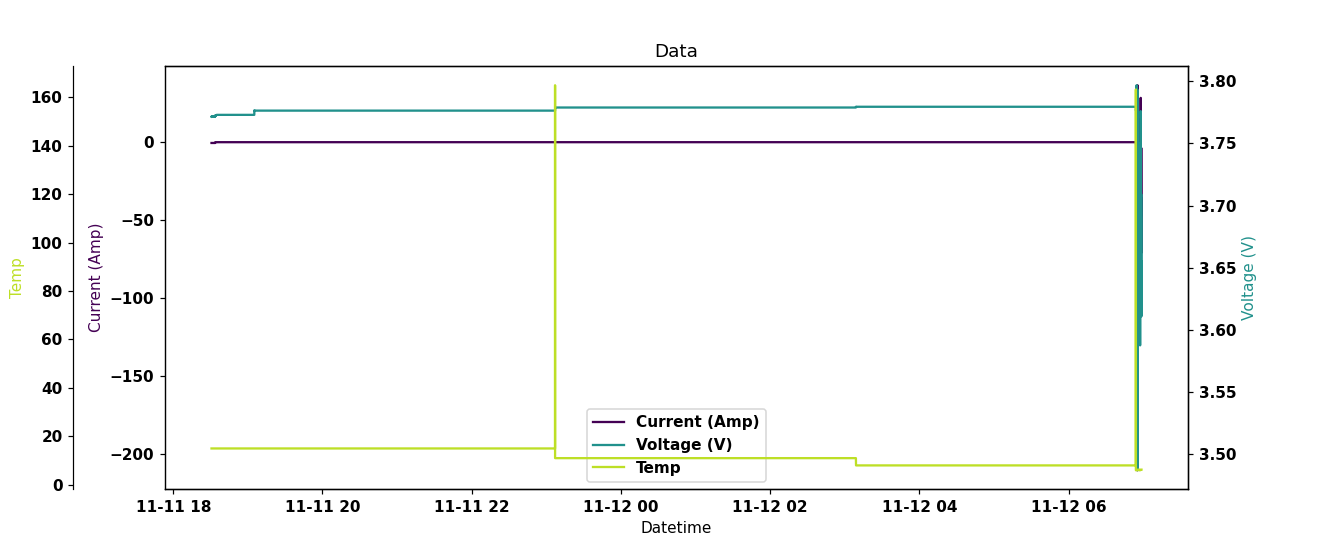

In [199]:
df_temp =  li_phase2_dfs[0].copy()
custom_plot.multi_scale_plot(("Data", plot_path), (df_temp['timestamp'], constants.x_label_datetime), (df_temp['current'], "Current (Amp)"), (df_temp['V'], "Voltage (V)"), (df_temp['Temp_mean'], "Temp"))

In [188]:
# combine data form both phases
li_dfs = li_phase1_dfs + li_phase2_dfs
print(len(li_dfs))
print(li_dfs[0])

217
                  timestamp  current       V  Temp
732498  2022-01-15 20:59:16      7.6  4.1014  12.0
732499  2022-01-15 20:59:17      7.6  4.1011  12.0
732500  2022-01-15 20:59:18      7.6  4.1011  12.0
735207  2022-01-15 20:59:19      7.6  4.1012  12.0
735208  2022-01-15 20:59:20      7.7  4.1011  12.0
...                     ...      ...     ...   ...
1030552 2022-01-19 07:01:44     -0.5  4.0136   2.5
1161093 2022-01-19 07:01:45     -0.6  4.0135   2.5
1030554 2022-01-19 07:01:46     -0.5  4.0136   2.5
1161095 2022-01-19 07:01:47     -0.5  4.0136   2.5
1030556 2022-01-19 07:01:48     -0.6  4.0136   2.5

[295353 rows x 4 columns]


In [190]:
# divide train and test cycles
import math

# Separate training, validation and test cycles, keep cycles without cell ID
TRAIN_SAMPLES = 0.85
num_cell_cycles = len(li_dfs)
num_train_cycles = math.floor(num_cell_cycles * TRAIN_SAMPLES)

li_train_cycles = li_dfs[0:num_train_cycles]
li_test_cycles = li_dfs[num_train_cycles:]


print(len(li_train_cycles), len(li_test_cycles))     # test

184 33


In [191]:
# no scaling, make sequence windows for train and test
WINDOW_SIZE = 10

train_seq = list()
test_seq = list()

for df in li_train_cycles:
    df_each_cycle = df.copy()
    X, y = df_to_supervised_univariate(df_each_cycle['current'], df_each_cycle['V'], WINDOW_SIZE)     # prepare sequences for each cycle
    train_seq.append((X,y))

for df in li_test_cycles:
    df_each_cycle = df.copy()
    X, y = df_to_supervised_univariate(df_each_cycle['current'], df_each_cycle['V'], WINDOW_SIZE)     # prepare sequences for each cycle
    test_seq.append((X,y))

print(len(train_seq), len(test_seq))

184 33


In [ ]:
model_path = os.path.join(cwd, 'univar_lstm_no_preprocess_win10')
log_path = os.path.join(cwd, 'univar_lstm_no_preprocess_win10', 'logs')

history = univariate_lstm(model_path, log_path, train_seq, 10)
print(history)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 32)                4352      
                                                                 
 dense_16 (Dense)            (None, 8)                 264       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________
cycle #  1
Epoch 1/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


177205/177205 - 929s - loss: 0.0265 - root_mean_squared_error: 0.1629 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968 - 929s/epoch - 5ms/step
Epoch 2/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


177205/177205 - 958s - loss: 2.6634e-04 - root_mean_squared_error: 0.0163 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578 - 958s/epoch - 5ms/step
Epoch 3/10
177205/177205 - 845s - loss: 1.2579e-04 - root_mean_squared_error: 0.0112 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635 - 845s/epoch - 5ms/step
Epoch 4/10
177205/177205 - 943s - loss: 1.0291e-04 - root_mean_squared_error: 0.0101 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607 - 943s/epoch - 5ms/step
Epoch 5/10
177205/177205 - 921s - loss: 9.4054e-05 - root_mean_squared_error: 0.0097 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620 - 921s/epoch - 5ms/step
Epoch 5: early stopping
cycle #  2
Epoch 1/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


50757/50757 - 226s - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576 - 226s/epoch - 4ms/step
Epoch 2/10
50757/50757 - 232s - loss: 1.7634e-04 - root_mean_squared_error: 0.0133 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0630 - 232s/epoch - 5ms/step
Epoch 3/10
50757/50757 - 224s - loss: 5.9969e-05 - root_mean_squared_error: 0.0077 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0682 - 224s/epoch - 4ms/step
Epoch 4/10
50757/50757 - 225s - loss: 3.9026e-05 - root_mean_squared_error: 0.0062 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677 - 225s/epoch - 4ms/step
Epoch 4: early stopping
cycle #  3
Epoch 1/10
85949/85949 - 394s - loss: 1.0647e-04 - root_mean_squared_error: 0.0103 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1306 - 394s/epoch - 5ms/step
Epoch 2/10
85949/85949 - 402s - loss: 2.9124e-04 - root_mean_squared_error: 0.0171 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1325 - 402s/epoch - 5ms/s

INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


163286/163286 - 764s - loss: 1.8635e-05 - root_mean_squared_error: 0.0043 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0545 - 764s/epoch - 5ms/step
Epoch 6/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


163286/163286 - 736s - loss: 1.9334e-05 - root_mean_squared_error: 0.0044 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535 - 736s/epoch - 5ms/step
Epoch 7/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


163286/163286 - 784s - loss: 1.7778e-05 - root_mean_squared_error: 0.0042 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524 - 784s/epoch - 5ms/step
Epoch 8/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


163286/163286 - 6929s - loss: 2.0481e-05 - root_mean_squared_error: 0.0045 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0518 - 6929s/epoch - 42ms/step
Epoch 9/10
163286/163286 - 915s - loss: 2.0986e-05 - root_mean_squared_error: 0.0046 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522 - 915s/epoch - 6ms/step
Epoch 10/10
163286/163286 - 909s - loss: 2.0330e-05 - root_mean_squared_error: 0.0045 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523 - 909s/epoch - 6ms/step
cycle #  5
Epoch 1/10
139481/139481 - 782s - loss: 7.7525e-05 - root_mean_squared_error: 0.0088 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107 - 782s/epoch - 6ms/step
Epoch 2/10
139481/139481 - 799s - loss: 2.8961e-05 - root_mean_squared_error: 0.0054 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105 - 799s/epoch - 6ms/step
Epoch 3/10
139481/139481 - 815s - loss: 3.0187e-05 - root_mean_squared_error: 0.0055 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105 - 815s/epoch - 6ms/step


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


26916/26916 - 147s - loss: 2.7918e-05 - root_mean_squared_error: 0.0053 - val_loss: 6.1873e-05 - val_root_mean_squared_error: 0.0079 - 147s/epoch - 5ms/step
Epoch 2/10
26916/26916 - 157s - loss: 4.9655e-08 - root_mean_squared_error: 2.2283e-04 - val_loss: 6.1987e-05 - val_root_mean_squared_error: 0.0079 - 157s/epoch - 6ms/step
Epoch 3/10
26916/26916 - 159s - loss: 5.2340e-08 - root_mean_squared_error: 2.2878e-04 - val_loss: 6.2337e-05 - val_root_mean_squared_error: 0.0079 - 159s/epoch - 6ms/step
Epoch 4/10
26916/26916 - 160s - loss: 3.3279e-08 - root_mean_squared_error: 1.8243e-04 - val_loss: 6.3132e-05 - val_root_mean_squared_error: 0.0079 - 160s/epoch - 6ms/step
Epoch 4: early stopping
cycle #  7
Epoch 1/10
12693/12693 - 70s - loss: 6.3258e-05 - root_mean_squared_error: 0.0080 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329 - 70s/epoch - 6ms/step
Epoch 2/10
12693/12693 - 73s - loss: 6.3537e-07 - root_mean_squared_error: 7.9710e-04 - val_loss: 9.4105e-04 - val_root_mean_squar

INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


437/437 - 12s - loss: 1.2491e-04 - root_mean_squared_error: 0.0112 - val_loss: 3.9143e-05 - val_root_mean_squared_error: 0.0063 - 12s/epoch - 27ms/step
Epoch 3/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


437/437 - 5s - loss: 5.2901e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.0231e-05 - val_root_mean_squared_error: 0.0045 - 5s/epoch - 13ms/step
Epoch 4/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


437/437 - 5s - loss: 2.0514e-05 - root_mean_squared_error: 0.0045 - val_loss: 1.2801e-05 - val_root_mean_squared_error: 0.0036 - 5s/epoch - 13ms/step
Epoch 5/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


437/437 - 7s - loss: 1.0487e-05 - root_mean_squared_error: 0.0032 - val_loss: 9.8544e-06 - val_root_mean_squared_error: 0.0031 - 7s/epoch - 15ms/step
Epoch 6/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


437/437 - 6s - loss: 7.1147e-06 - root_mean_squared_error: 0.0027 - val_loss: 7.9963e-06 - val_root_mean_squared_error: 0.0028 - 6s/epoch - 14ms/step
Epoch 7/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


437/437 - 6s - loss: 5.8446e-06 - root_mean_squared_error: 0.0024 - val_loss: 6.4475e-06 - val_root_mean_squared_error: 0.0025 - 6s/epoch - 14ms/step
Epoch 8/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


437/437 - 7s - loss: 5.9950e-06 - root_mean_squared_error: 0.0024 - val_loss: 5.4154e-06 - val_root_mean_squared_error: 0.0023 - 7s/epoch - 16ms/step
Epoch 9/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


437/437 - 6s - loss: 7.3242e-06 - root_mean_squared_error: 0.0027 - val_loss: 4.2803e-06 - val_root_mean_squared_error: 0.0021 - 6s/epoch - 13ms/step
Epoch 10/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


437/437 - 6s - loss: 9.6703e-06 - root_mean_squared_error: 0.0031 - val_loss: 2.9484e-06 - val_root_mean_squared_error: 0.0017 - 6s/epoch - 13ms/step
cycle #  9
Epoch 1/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


1001/1001 - 9s - loss: 1.0231e-07 - root_mean_squared_error: 3.1987e-04 - val_loss: 1.0413e-06 - val_root_mean_squared_error: 0.0010 - 9s/epoch - 9ms/step
Epoch 2/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


1001/1001 - 10s - loss: 7.4443e-08 - root_mean_squared_error: 2.7284e-04 - val_loss: 1.0170e-06 - val_root_mean_squared_error: 0.0010 - 10s/epoch - 10ms/step
Epoch 3/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


1001/1001 - 9s - loss: 3.9633e-08 - root_mean_squared_error: 1.9908e-04 - val_loss: 9.9381e-07 - val_root_mean_squared_error: 9.9690e-04 - 9s/epoch - 9ms/step
Epoch 4/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


1001/1001 - 9s - loss: 3.4558e-08 - root_mean_squared_error: 1.8590e-04 - val_loss: 9.5528e-07 - val_root_mean_squared_error: 9.7738e-04 - 9s/epoch - 9ms/step
Epoch 5/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


1001/1001 - 10s - loss: 3.9142e-08 - root_mean_squared_error: 1.9784e-04 - val_loss: 9.1512e-07 - val_root_mean_squared_error: 9.5662e-04 - 10s/epoch - 10ms/step
Epoch 6/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


1001/1001 - 9s - loss: 4.1125e-08 - root_mean_squared_error: 2.0279e-04 - val_loss: 8.7405e-07 - val_root_mean_squared_error: 9.3491e-04 - 9s/epoch - 9ms/step
Epoch 7/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


1001/1001 - 9s - loss: 4.5348e-08 - root_mean_squared_error: 2.1295e-04 - val_loss: 8.2152e-07 - val_root_mean_squared_error: 9.0638e-04 - 9s/epoch - 9ms/step
Epoch 8/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


1001/1001 - 11s - loss: 4.7383e-08 - root_mean_squared_error: 2.1768e-04 - val_loss: 7.4936e-07 - val_root_mean_squared_error: 8.6565e-04 - 11s/epoch - 11ms/step
Epoch 9/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


1001/1001 - 8s - loss: 5.0627e-08 - root_mean_squared_error: 2.2500e-04 - val_loss: 6.6736e-07 - val_root_mean_squared_error: 8.1692e-04 - 8s/epoch - 8ms/step
Epoch 10/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


1001/1001 - 9s - loss: 5.0109e-08 - root_mean_squared_error: 2.2385e-04 - val_loss: 5.8257e-07 - val_root_mean_squared_error: 7.6326e-04 - 9s/epoch - 9ms/step
cycle #  10
Epoch 1/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


10115/10115 - 64s - loss: 1.1970e-08 - root_mean_squared_error: 1.0941e-04 - val_loss: 5.0683e-10 - val_root_mean_squared_error: 2.2513e-05 - 64s/epoch - 6ms/step
Epoch 2/10
10115/10115 - 61s - loss: 7.8730e-08 - root_mean_squared_error: 2.8059e-04 - val_loss: 5.0683e-10 - val_root_mean_squared_error: 2.2513e-05 - 61s/epoch - 6ms/step
Epoch 3/10
10115/10115 - 61s - loss: 8.2802e-08 - root_mean_squared_error: 2.8775e-04 - val_loss: 5.0683e-10 - val_root_mean_squared_error: 2.2513e-05 - 61s/epoch - 6ms/step
Epoch 4/10
10115/10115 - 60s - loss: 6.7317e-08 - root_mean_squared_error: 2.5945e-04 - val_loss: 5.0683e-10 - val_root_mean_squared_error: 2.2513e-05 - 60s/epoch - 6ms/step
Epoch 4: early stopping
cycle #  11
Epoch 1/10
8225/8225 - 46s - loss: 9.7156e-08 - root_mean_squared_error: 3.1170e-04 - val_loss: 7.1566e-08 - val_root_mean_squared_error: 2.6752e-04 - 46s/epoch - 6ms/step
Epoch 2/10
8225/8225 - 46s - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 7.1566e-08 

cycle #  17
Epoch 1/10
1048/1048 - 6s - loss: 6.3003e-05 - root_mean_squared_error: 0.0079 - val_loss: 5.7290e-07 - val_root_mean_squared_error: 7.5690e-04 - 6s/epoch - 6ms/step
Epoch 2/10
1048/1048 - 5s - loss: 2.0499e-05 - root_mean_squared_error: 0.0045 - val_loss: 4.6541e-07 - val_root_mean_squared_error: 6.8221e-04 - 5s/epoch - 5ms/step
Epoch 3/10
1048/1048 - 6s - loss: 1.6266e-05 - root_mean_squared_error: 0.0040 - val_loss: 6.8034e-07 - val_root_mean_squared_error: 8.2483e-04 - 6s/epoch - 6ms/step
Epoch 4/10
1048/1048 - 6s - loss: 1.4482e-05 - root_mean_squared_error: 0.0038 - val_loss: 3.9553e-07 - val_root_mean_squared_error: 6.2891e-04 - 6s/epoch - 6ms/step
Epoch 5/10
1048/1048 - 5s - loss: 1.2193e-05 - root_mean_squared_error: 0.0035 - val_loss: 2.8073e-07 - val_root_mean_squared_error: 5.2984e-04 - 5s/epoch - 5ms/step
Epoch 6/10
1048/1048 - 6s - loss: 9.3532e-06 - root_mean_squared_error: 0.0031 - val_loss: 1.8406e-06 - val_root_mean_squared_error: 0.0014 - 6s/epoch - 6ms/s

Epoch 2/10
14354/14354 - 82s - loss: 2.0951e-08 - root_mean_squared_error: 1.4474e-04 - val_loss: 6.7699e-07 - val_root_mean_squared_error: 8.2279e-04 - 82s/epoch - 6ms/step
Epoch 3/10
14354/14354 - 83s - loss: 2.7186e-08 - root_mean_squared_error: 1.6488e-04 - val_loss: 6.6889e-07 - val_root_mean_squared_error: 8.1786e-04 - 83s/epoch - 6ms/step
Epoch 4/10
14354/14354 - 86s - loss: 2.1814e-08 - root_mean_squared_error: 1.4770e-04 - val_loss: 6.6291e-07 - val_root_mean_squared_error: 8.1419e-04 - 86s/epoch - 6ms/step
Epoch 5/10
14354/14354 - 87s - loss: 2.3975e-08 - root_mean_squared_error: 1.5484e-04 - val_loss: 6.5524e-07 - val_root_mean_squared_error: 8.0947e-04 - 87s/epoch - 6ms/step
Epoch 6/10
14354/14354 - 85s - loss: 3.2748e-08 - root_mean_squared_error: 1.8096e-04 - val_loss: 6.5916e-07 - val_root_mean_squared_error: 8.1189e-04 - 85s/epoch - 6ms/step
Epoch 7/10
14354/14354 - 76s - loss: 2.4258e-08 - root_mean_squared_error: 1.5575e-04 - val_loss: 6.4327e-07 - val_root_mean_squar

INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


2563/2563 - 18s - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 2.5125e-10 - val_root_mean_squared_error: 1.5851e-05 - 18s/epoch - 7ms/step
Epoch 2/10
2563/2563 - 14s - loss: 2.0894e-07 - root_mean_squared_error: 4.5710e-04 - val_loss: 2.5125e-10 - val_root_mean_squared_error: 1.5851e-05 - 14s/epoch - 5ms/step
Epoch 3/10
2563/2563 - 14s - loss: 1.8024e-07 - root_mean_squared_error: 4.2455e-04 - val_loss: 2.5125e-10 - val_root_mean_squared_error: 1.5851e-05 - 14s/epoch - 6ms/step
Epoch 4/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


2563/2563 - 19s - loss: 1.4630e-07 - root_mean_squared_error: 3.8249e-04 - val_loss: 2.4997e-10 - val_root_mean_squared_error: 1.5811e-05 - 19s/epoch - 7ms/step
Epoch 5/10
2563/2563 - 15s - loss: 1.6169e-07 - root_mean_squared_error: 4.0211e-04 - val_loss: 2.5782e-10 - val_root_mean_squared_error: 1.6057e-05 - 15s/epoch - 6ms/step
Epoch 6/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


2563/2563 - 20s - loss: 1.7600e-07 - root_mean_squared_error: 4.1952e-04 - val_loss: 2.4941e-10 - val_root_mean_squared_error: 1.5793e-05 - 20s/epoch - 8ms/step
Epoch 7/10
2563/2563 - 12s - loss: 1.8055e-07 - root_mean_squared_error: 4.2492e-04 - val_loss: 2.5299e-10 - val_root_mean_squared_error: 1.5906e-05 - 12s/epoch - 5ms/step
Epoch 8/10
2563/2563 - 14s - loss: 1.8421e-07 - root_mean_squared_error: 4.2920e-04 - val_loss: 2.5125e-10 - val_root_mean_squared_error: 1.5851e-05 - 14s/epoch - 5ms/step
Epoch 9/10
2563/2563 - 14s - loss: 1.8780e-07 - root_mean_squared_error: 4.3336e-04 - val_loss: 2.5125e-10 - val_root_mean_squared_error: 1.5851e-05 - 14s/epoch - 5ms/step
Epoch 9: early stopping
cycle #  31
Epoch 1/10
439/439 - 2s - loss: 1.7647e-06 - root_mean_squared_error: 0.0013 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578 - 2s/epoch - 5ms/step
Epoch 2/10
439/439 - 3s - loss: 9.0753e-07 - root_mean_squared_error: 9.5264e-04 - val_loss: 0.0033 - val_root_mean_squared_error: 

Epoch 3/10
4781/4781 - 28s - loss: 1.0496e-07 - root_mean_squared_error: 3.2398e-04 - val_loss: 5.1490e-05 - val_root_mean_squared_error: 0.0072 - 28s/epoch - 6ms/step
Epoch 4/10
4781/4781 - 27s - loss: 7.6402e-08 - root_mean_squared_error: 2.7641e-04 - val_loss: 4.5083e-05 - val_root_mean_squared_error: 0.0067 - 27s/epoch - 6ms/step
Epoch 5/10
4781/4781 - 27s - loss: 5.3963e-08 - root_mean_squared_error: 2.3230e-04 - val_loss: 4.1248e-05 - val_root_mean_squared_error: 0.0064 - 27s/epoch - 6ms/step
Epoch 6/10
4781/4781 - 28s - loss: 4.6570e-08 - root_mean_squared_error: 2.1580e-04 - val_loss: 4.1845e-05 - val_root_mean_squared_error: 0.0065 - 28s/epoch - 6ms/step
Epoch 7/10
4781/4781 - 28s - loss: 4.4790e-08 - root_mean_squared_error: 2.1164e-04 - val_loss: 4.9025e-05 - val_root_mean_squared_error: 0.0070 - 28s/epoch - 6ms/step
Epoch 8/10
4781/4781 - 28s - loss: 4.8256e-08 - root_mean_squared_error: 2.1967e-04 - val_loss: 6.2777e-05 - val_root_mean_squared_error: 0.0079 - 28s/epoch - 6

Epoch 3/10
4593/4593 - 26s - loss: 1.8599e-08 - root_mean_squared_error: 1.3638e-04 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390 - 26s/epoch - 6ms/step
Epoch 4/10
4593/4593 - 27s - loss: 1.8200e-08 - root_mean_squared_error: 1.3491e-04 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390 - 27s/epoch - 6ms/step
Epoch 5/10
4593/4593 - 26s - loss: 1.5754e-08 - root_mean_squared_error: 1.2552e-04 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390 - 26s/epoch - 6ms/step
Epoch 6/10
4593/4593 - 24s - loss: 3.5464e-08 - root_mean_squared_error: 1.8832e-04 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390 - 24s/epoch - 5ms/step
Epoch 7/10
4593/4593 - 24s - loss: 3.1031e-08 - root_mean_squared_error: 1.7616e-04 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389 - 24s/epoch - 5ms/step
Epoch 8/10
4593/4593 - 26s - loss: 3.2012e-08 - root_mean_squared_error: 1.7892e-04 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389 - 26s/epoch - 6ms/step
Epoch 9/10
4593/

Epoch 3/10
37495/37495 - 205s - loss: 1.8212e-05 - root_mean_squared_error: 0.0043 - val_loss: 8.5096e-04 - val_root_mean_squared_error: 0.0292 - 205s/epoch - 5ms/step
Epoch 4/10
37495/37495 - 216s - loss: 1.4025e-05 - root_mean_squared_error: 0.0037 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451 - 216s/epoch - 6ms/step
Epoch 5/10
37495/37495 - 212s - loss: 8.3752e-06 - root_mean_squared_error: 0.0029 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392 - 212s/epoch - 6ms/step
Epoch 5: early stopping
cycle #  50
Epoch 1/10
9766/9766 - 54s - loss: 1.7943e-06 - root_mean_squared_error: 0.0013 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384 - 54s/epoch - 6ms/step
Epoch 2/10
9766/9766 - 50s - loss: 4.1360e-08 - root_mean_squared_error: 2.0337e-04 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385 - 50s/epoch - 5ms/step
Epoch 3/10
9766/9766 - 55s - loss: 3.9083e-08 - root_mean_squared_error: 1.9769e-04 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385 - 5

Epoch 2/10
1664/1664 - 9s - loss: 1.5446e-07 - root_mean_squared_error: 3.9301e-04 - val_loss: 7.3734e-08 - val_root_mean_squared_error: 2.7154e-04 - 9s/epoch - 5ms/step
Epoch 3/10
1664/1664 - 9s - loss: 1.5760e-07 - root_mean_squared_error: 3.9699e-04 - val_loss: 7.3734e-08 - val_root_mean_squared_error: 2.7154e-04 - 9s/epoch - 5ms/step
Epoch 4/10
1664/1664 - 9s - loss: 1.4040e-07 - root_mean_squared_error: 3.7471e-04 - val_loss: 7.3734e-08 - val_root_mean_squared_error: 2.7154e-04 - 9s/epoch - 5ms/step
Epoch 4: early stopping
cycle #  58
Epoch 1/10
312/312 - 1s - loss: 7.2270e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.7040e-04 - val_root_mean_squared_error: 0.0164 - 1s/epoch - 5ms/step
Epoch 2/10
312/312 - 2s - loss: 5.7911e-05 - root_mean_squared_error: 0.0076 - val_loss: 8.1969e-05 - val_root_mean_squared_error: 0.0091 - 2s/epoch - 6ms/step
Epoch 3/10
312/312 - 2s - loss: 1.6722e-05 - root_mean_squared_error: 0.0041 - val_loss: 7.8162e-05 - val_root_mean_squared_error: 0.0

Epoch 4/10
20544/20544 - 120s - loss: 2.3155e-08 - root_mean_squared_error: 1.5217e-04 - val_loss: 1.4234e-05 - val_root_mean_squared_error: 0.0038 - 120s/epoch - 6ms/step
Epoch 5/10
20544/20544 - 122s - loss: 2.9933e-08 - root_mean_squared_error: 1.7301e-04 - val_loss: 1.5767e-05 - val_root_mean_squared_error: 0.0040 - 122s/epoch - 6ms/step
Epoch 6/10
20544/20544 - 117s - loss: 2.9004e-08 - root_mean_squared_error: 1.7030e-04 - val_loss: 1.6857e-05 - val_root_mean_squared_error: 0.0041 - 117s/epoch - 6ms/step
Epoch 7/10
20544/20544 - 120s - loss: 2.4481e-08 - root_mean_squared_error: 1.5646e-04 - val_loss: 1.8013e-05 - val_root_mean_squared_error: 0.0042 - 120s/epoch - 6ms/step
Epoch 7: early stopping
cycle #  65
Epoch 1/10
18526/18526 - 109s - loss: 5.4343e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.2204e-04 - val_root_mean_squared_error: 0.0110 - 109s/epoch - 6ms/step
Epoch 2/10
18526/18526 - 107s - loss: 8.2331e-07 - root_mean_squared_error: 9.0737e-04 - val_loss: 1.4223e-0

INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


19904/19904 - 124s - loss: 3.5993e-08 - root_mean_squared_error: 1.8972e-04 - val_loss: 1.4552e-11 - val_root_mean_squared_error: 3.8147e-06 - 124s/epoch - 6ms/step
Epoch 2/10


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


INFO:tensorflow:Assets written to: C:\Users\s.kaiser\Experiments\MuleCarData\univar_lstm_no_preprocess_win10\assets


19904/19904 - 109s - loss: 4.3026e-08 - root_mean_squared_error: 2.0743e-04 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00 - 109s/epoch - 5ms/step
Epoch 3/10
19904/19904 - 115s - loss: 3.6938e-08 - root_mean_squared_error: 1.9219e-04 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00 - 115s/epoch - 6ms/step
Epoch 4/10
19904/19904 - 110s - loss: 1.7672e-08 - root_mean_squared_error: 1.3294e-04 - val_loss: 8.1855e-12 - val_root_mean_squared_error: 2.8610e-06 - 110s/epoch - 6ms/step
Epoch 5/10
19904/19904 - 112s - loss: 4.1976e-08 - root_mean_squared_error: 2.0488e-04 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00 - 112s/epoch - 6ms/step
Epoch 5: early stopping
cycle #  69
Epoch 1/10
36228/36228 - 202s - loss: 3.1044e-08 - root_mean_squared_error: 1.7619e-04 - val_loss: 9.0577e-05 - val_root_mean_squared_error: 0.0095 - 202s/epoch - 6ms/step
Epoch 2/10
36228/36228 - 211s - loss: 3.6257e-08 - root_mean_squared_error: 1.9041e-04 - val_loss: 

Epoch 2/10
33411/33411 - 192s - loss: 3.4809e-07 - root_mean_squared_error: 5.8999e-04 - val_loss: 7.0994e-04 - val_root_mean_squared_error: 0.0266 - 192s/epoch - 6ms/step
Epoch 3/10
33411/33411 - 200s - loss: 4.0800e-07 - root_mean_squared_error: 6.3875e-04 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348 - 200s/epoch - 6ms/step
Epoch 4/10
33411/33411 - 190s - loss: 1.9911e-07 - root_mean_squared_error: 4.4622e-04 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375 - 190s/epoch - 6ms/step
Epoch 5/10
33411/33411 - 191s - loss: 3.4474e-07 - root_mean_squared_error: 5.8715e-04 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426 - 191s/epoch - 6ms/step
Epoch 5: early stopping
cycle #  77
Epoch 1/10
417/417 - 2s - loss: 0.0111 - root_mean_squared_error: 0.1053 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846 - 2s/epoch - 5ms/step
Epoch 2/10
417/417 - 2s - loss: 0.0031 - root_mean_squared_error: 0.0554 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345 - 2s/e

Epoch 8/10
2722/2722 - 15s - loss: 5.1758e-08 - root_mean_squared_error: 2.2750e-04 - val_loss: 7.1419e-05 - val_root_mean_squared_error: 0.0085 - 15s/epoch - 6ms/step
Epoch 9/10
2722/2722 - 16s - loss: 5.1567e-08 - root_mean_squared_error: 2.2708e-04 - val_loss: 7.0360e-05 - val_root_mean_squared_error: 0.0084 - 16s/epoch - 6ms/step
Epoch 10/10
2722/2722 - 16s - loss: 5.1413e-08 - root_mean_squared_error: 2.2674e-04 - val_loss: 6.9299e-05 - val_root_mean_squared_error: 0.0083 - 16s/epoch - 6ms/step
cycle #  83
Epoch 1/10
10959/10959 - 61s - loss: 3.8137e-05 - root_mean_squared_error: 0.0062 - val_loss: 2.1422e-06 - val_root_mean_squared_error: 0.0015 - 61s/epoch - 6ms/step
Epoch 2/10
10959/10959 - 64s - loss: 8.2773e-06 - root_mean_squared_error: 0.0029 - val_loss: 3.3142e-06 - val_root_mean_squared_error: 0.0018 - 64s/epoch - 6ms/step
Epoch 3/10
10959/10959 - 65s - loss: 8.9944e-06 - root_mean_squared_error: 0.0030 - val_loss: 3.4447e-06 - val_root_mean_squared_error: 0.0019 - 65s/ep

Epoch 7/10
556/556 - 3s - loss: 2.8586e-07 - root_mean_squared_error: 5.3466e-04 - val_loss: 6.2840e-04 - val_root_mean_squared_error: 0.0251 - 3s/epoch - 6ms/step
Epoch 8/10
556/556 - 3s - loss: 2.3058e-07 - root_mean_squared_error: 4.8019e-04 - val_loss: 6.2387e-04 - val_root_mean_squared_error: 0.0250 - 3s/epoch - 6ms/step
Epoch 9/10
556/556 - 3s - loss: 2.1284e-07 - root_mean_squared_error: 4.6135e-04 - val_loss: 6.1921e-04 - val_root_mean_squared_error: 0.0249 - 3s/epoch - 5ms/step
Epoch 10/10
556/556 - 3s - loss: 2.1794e-07 - root_mean_squared_error: 4.6684e-04 - val_loss: 6.1491e-04 - val_root_mean_squared_error: 0.0248 - 3s/epoch - 6ms/step
cycle #  90
Epoch 1/10
2087/2087 - 12s - loss: 5.5316e-08 - root_mean_squared_error: 2.3519e-04 - val_loss: 6.9614e-05 - val_root_mean_squared_error: 0.0083 - 12s/epoch - 6ms/step
Epoch 2/10
2087/2087 - 12s - loss: 8.7342e-08 - root_mean_squared_error: 2.9554e-04 - val_loss: 6.8189e-05 - val_root_mean_squared_error: 0.0083 - 12s/epoch - 6ms/

Epoch 3/10
13396/13396 - 77s - loss: 4.3033e-08 - root_mean_squared_error: 2.0744e-04 - val_loss: 4.2359e-06 - val_root_mean_squared_error: 0.0021 - 77s/epoch - 6ms/step
Epoch 4/10
13396/13396 - 81s - loss: 2.8713e-08 - root_mean_squared_error: 1.6945e-04 - val_loss: 3.9935e-06 - val_root_mean_squared_error: 0.0020 - 81s/epoch - 6ms/step
Epoch 5/10
13396/13396 - 79s - loss: 4.6728e-08 - root_mean_squared_error: 2.1617e-04 - val_loss: 3.8322e-06 - val_root_mean_squared_error: 0.0020 - 79s/epoch - 6ms/step
Epoch 6/10
13396/13396 - 77s - loss: 5.1679e-08 - root_mean_squared_error: 2.2733e-04 - val_loss: 3.7464e-06 - val_root_mean_squared_error: 0.0019 - 77s/epoch - 6ms/step
Epoch 7/10
13396/13396 - 76s - loss: 6.2066e-08 - root_mean_squared_error: 2.4913e-04 - val_loss: 3.7442e-06 - val_root_mean_squared_error: 0.0019 - 76s/epoch - 6ms/step
Epoch 8/10
13396/13396 - 73s - loss: 2.9713e-08 - root_mean_squared_error: 1.7237e-04 - val_loss: 3.6317e-06 - val_root_mean_squared_error: 0.0019 - 7

Epoch 10/10
4902/4902 - 29s - loss: 3.3907e-05 - root_mean_squared_error: 0.0058 - val_loss: 3.4883e-06 - val_root_mean_squared_error: 0.0019 - 29s/epoch - 6ms/step
cycle #  104
Epoch 1/10
4235/4235 - 24s - loss: 3.2193e-05 - root_mean_squared_error: 0.0057 - val_loss: 2.6419e-05 - val_root_mean_squared_error: 0.0051 - 24s/epoch - 6ms/step
Epoch 2/10
4235/4235 - 23s - loss: 1.1707e-05 - root_mean_squared_error: 0.0034 - val_loss: 4.1731e-05 - val_root_mean_squared_error: 0.0065 - 23s/epoch - 5ms/step
Epoch 3/10
4235/4235 - 22s - loss: 1.0231e-05 - root_mean_squared_error: 0.0032 - val_loss: 3.6426e-05 - val_root_mean_squared_error: 0.0060 - 22s/epoch - 5ms/step
Epoch 4/10
4235/4235 - 24s - loss: 9.0374e-06 - root_mean_squared_error: 0.0030 - val_loss: 2.6597e-05 - val_root_mean_squared_error: 0.0052 - 24s/epoch - 6ms/step
Epoch 4: early stopping
cycle #  105
Epoch 1/10
14982/14982 - 84s - loss: 9.4805e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.2490e-04 - val_root_mean_squared_

Epoch 2/10
29524/29524 - 168s - loss: 4.9209e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.0131e-06 - val_root_mean_squared_error: 0.0010 - 168s/epoch - 6ms/step
Epoch 3/10
29524/29524 - 178s - loss: 4.6382e-06 - root_mean_squared_error: 0.0022 - val_loss: 1.3275e-06 - val_root_mean_squared_error: 0.0012 - 178s/epoch - 6ms/step
Epoch 4/10
29524/29524 - 164s - loss: 2.9961e-06 - root_mean_squared_error: 0.0017 - val_loss: 1.5014e-06 - val_root_mean_squared_error: 0.0012 - 164s/epoch - 6ms/step
Epoch 5/10
29524/29524 - 165s - loss: 2.9075e-06 - root_mean_squared_error: 0.0017 - val_loss: 1.4673e-06 - val_root_mean_squared_error: 0.0012 - 165s/epoch - 6ms/step
Epoch 5: early stopping
cycle #  112
Epoch 1/10
316/316 - 2s - loss: 8.6987e-04 - root_mean_squared_error: 0.0295 - val_loss: 9.0839e-04 - val_root_mean_squared_error: 0.0301 - 2s/epoch - 5ms/step
Epoch 2/10
316/316 - 2s - loss: 2.2113e-05 - root_mean_squared_error: 0.0047 - val_loss: 2.4102e-05 - val_root_mean_squared_error: 

Epoch 3/10
616/616 - 4s - loss: 1.1629e-09 - root_mean_squared_error: 3.4102e-05 - val_loss: 5.1919e-05 - val_root_mean_squared_error: 0.0072 - 4s/epoch - 6ms/step
Epoch 4/10
616/616 - 3s - loss: 1.4318e-09 - root_mean_squared_error: 3.7839e-05 - val_loss: 5.1938e-05 - val_root_mean_squared_error: 0.0072 - 3s/epoch - 5ms/step
Epoch 5/10
616/616 - 3s - loss: 2.0225e-09 - root_mean_squared_error: 4.4972e-05 - val_loss: 5.1908e-05 - val_root_mean_squared_error: 0.0072 - 3s/epoch - 5ms/step
Epoch 5: early stopping
cycle #  120
Epoch 1/10
630/630 - 3s - loss: 4.0413e-08 - root_mean_squared_error: 2.0103e-04 - val_loss: 4.9840e-05 - val_root_mean_squared_error: 0.0071 - 3s/epoch - 5ms/step
Epoch 2/10
630/630 - 4s - loss: 1.7512e-08 - root_mean_squared_error: 1.3233e-04 - val_loss: 5.0297e-05 - val_root_mean_squared_error: 0.0071 - 4s/epoch - 6ms/step
Epoch 3/10
630/630 - 3s - loss: 2.1235e-08 - root_mean_squared_error: 1.4572e-04 - val_loss: 5.0198e-05 - val_root_mean_squared_error: 0.0071 -

Epoch 4: early stopping
cycle #  127
Epoch 1/10
577/577 - 3s - loss: 8.1445e-07 - root_mean_squared_error: 9.0247e-04 - val_loss: 6.1417e-05 - val_root_mean_squared_error: 0.0078 - 3s/epoch - 5ms/step
Epoch 2/10
577/577 - 3s - loss: 5.6050e-09 - root_mean_squared_error: 7.4867e-05 - val_loss: 6.1164e-05 - val_root_mean_squared_error: 0.0078 - 3s/epoch - 6ms/step
Epoch 3/10
577/577 - 3s - loss: 7.2578e-09 - root_mean_squared_error: 8.5193e-05 - val_loss: 6.0433e-05 - val_root_mean_squared_error: 0.0078 - 3s/epoch - 6ms/step
Epoch 4/10
577/577 - 3s - loss: 7.0431e-09 - root_mean_squared_error: 8.3923e-05 - val_loss: 6.2298e-05 - val_root_mean_squared_error: 0.0079 - 3s/epoch - 4ms/step
Epoch 5/10
577/577 - 3s - loss: 1.2172e-08 - root_mean_squared_error: 1.1033e-04 - val_loss: 6.2459e-05 - val_root_mean_squared_error: 0.0079 - 3s/epoch - 5ms/step
Epoch 6/10
577/577 - 3s - loss: 1.3455e-08 - root_mean_squared_error: 1.1600e-04 - val_loss: 5.9036e-05 - val_root_mean_squared_error: 0.0077 -

Epoch 7/10
20157/20157 - 115s - loss: 3.3029e-08 - root_mean_squared_error: 1.8174e-04 - val_loss: 1.0501e-04 - val_root_mean_squared_error: 0.0102 - 115s/epoch - 6ms/step
Epoch 8/10
20157/20157 - 99s - loss: 3.1806e-08 - root_mean_squared_error: 1.7834e-04 - val_loss: 1.0509e-04 - val_root_mean_squared_error: 0.0103 - 99s/epoch - 5ms/step
Epoch 9/10
20157/20157 - 107s - loss: 3.3519e-08 - root_mean_squared_error: 1.8308e-04 - val_loss: 1.0492e-04 - val_root_mean_squared_error: 0.0102 - 107s/epoch - 5ms/step
Epoch 10/10
20157/20157 - 110s - loss: 3.2780e-08 - root_mean_squared_error: 1.8105e-04 - val_loss: 1.0485e-04 - val_root_mean_squared_error: 0.0102 - 110s/epoch - 5ms/step
cycle #  133
Epoch 1/10
1919/1919 - 10s - loss: 5.6943e-05 - root_mean_squared_error: 0.0075 - val_loss: 7.2024e-06 - val_root_mean_squared_error: 0.0027 - 10s/epoch - 5ms/step
Epoch 2/10
1919/1919 - 11s - loss: 1.6039e-05 - root_mean_squared_error: 0.0040 - val_loss: 7.2024e-06 - val_root_mean_squared_error: 0.

In [ ]:
# Save history for plotting later
import pickle
dir_path = os.path.join(cwd, 'univar_lstm_no_preprocess_win10')
src_path = os.path.join(dir_path, 'univar_lstm_no_preprocess_win10_history.pkl')

with open(src_path, 'wb') as f:
    pickle.dump(history.history, f)
print(history.history)

In [ ]:
# Plot train vs val loss
import pickle
# load last saved df and convert time stamp and sort
dir_path = os.path.join(cwd, 'univar_lstm_no_preprocess_win10')
src_path = os.path.join(dir_path, 'univar_lstm_no_preprocess_win10_history.pkl')

with open(src_path, 'rb') as f:
    dict_history = pickle.load(f)

In [ ]:
# Plot history (train, val loss vs epochs)

dir_path = os.path.join(cwd, 'univar_lstm_no_preprocess_win10')
src_path = os.path.join(dir_path, 'loss_train_vs_val.pdf')

import matplotlib
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 10}

matplotlib.rc('font', **font)
fig = plt.figure(figsize =(12 ,5))

plt.plot(dict_history['loss'])
plt.plot(dict_history['val_loss'])
plt.title('Univariate model loss for pre-processed cycles with recurrent dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
fig.savefig(src_path)

### Show corelation between current and voltage
1. The correlation throws absolutely no light on questions of process or causation. It's just a descriptive measure of strength of linear association.
2. Correlation coefficient means how much two series vary together
3. Corrleation 1 means two series strongly vary together, have perfect linear relationship with no deviation
4. High correlation means 2 series strongly vary together
5. Low correlation menas they vary together but weak association
6. 

<IPython.core.display.Javascript object>


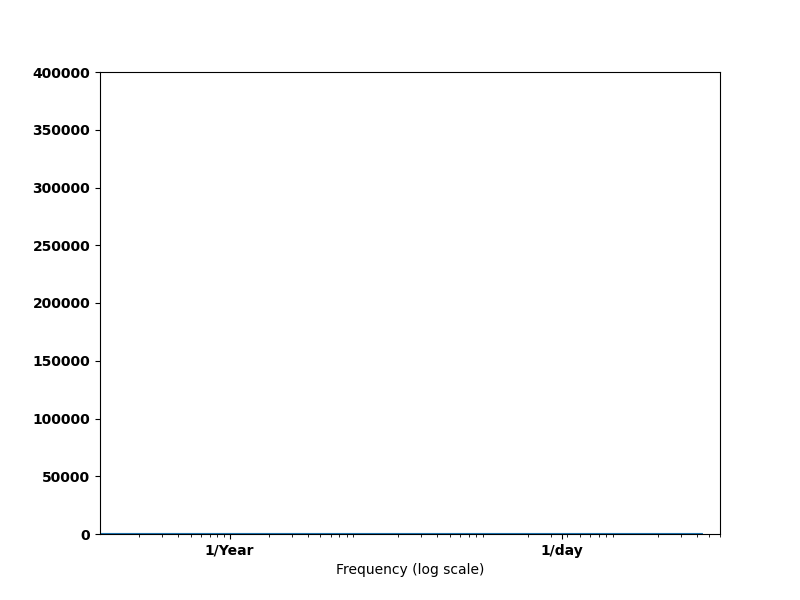

In [102]:
%matplotlib notebook

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

, li_cycles = li_ts_cycles[0]
df_temp = li_cycles[4]

fft = tf.signal.rfft(df_temp['V'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_temp['V'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Univariate: use only current for LSTM model
1. An LSTM layer requires a three-dimensional input (#data_points, input time_steps, #variables)
2. LSTMs by default will produce a two-dimensional output  as an interpretation from the end of the sequence.
3. Consider running example a few times and compare the average outcome.

## Types of time series prediction
### A. Multiple input time series (mutlivariate time series)
1. Multiple variables over same TS, but prediction happens for one varaible
2. Example: Time series inputs: V, I, T 
   Output/prediction has to be made on V
4. Rephrase: how V changes with time wrt temporal values of V, I, T 

### B. Multiple parallel time series
1. There are several time series, each for separate variable
2. All the time series have same #time_steps
3. Data can be prepared in a way so that LSTM trains parallelly on each time series and predits on each variable (each column)
4. What if the parallel time serieses have different length i.e. variable total #time_steps?

### C. Multiple input-multiple parallel time series: multivariate and multiple parallel TS (A and B together)
1. Multiple time series samples, each TS being multivariate (this is the scenario)

In [130]:
print(len(li_train_cycles), len(li_validation_cycles), len(li_test_cycles))


515 101 10


In [110]:
# not hyperparams
verbose = 2       # will just mention the number of epoch like this epoch 1/10, 2/10 etc. while training

### Normalization vs standardization
1. Standardization assumes that your data has a Gaussian (bell curve) distribution
2. Normalization is a good technique to use when you do not know the distribution of your data or when you know the distribution is not Gaussian (a bell curve). Normalization is useful when your data has varying scales and the algorithm you are using does not make assumptions about the distribution of your data, such as k-nearest neighbors and artificial neural networks.
3. See details here: https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
4. Only input features should be normalized/scaled. Scaling outputs/labels has no effect on training: https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re

### Decision: use min-max feature scaling (normalization) since we do not want to assume anything about the distribution of the data
### NB: to prevent data leak, normalization should be done only on the training data and then applied to validation dataset (but we have disjoint time series/multiple parallel time series). However, because I have disjoint 

In [171]:
# scale train and test data to [-1, 1]
def scale(df_train, df_val, df_test, type):       # type is the type of scaling, eg standard, normal etc.
    scaler_train = StandardScaler().fit(df_train)    # just fit, not transform yet
    train_scaled = scaler_train.transform(df_train)

    scaler_val = StandardScaler().fit(df_val)
    val_scaled = scaler_val.transform(df_val)
    
#     scaler_test = StandardScaler().fit(df_test)
#     test_scaled = scaler_test.transform(scaler_test)

    return train_scaled, val_scaled, df_test

# def get_min_max_normalized_df(df_original, df_scaled):
#     df_result = df_scaled * ((df_original.max() - df_original.min()) + df_original.min()
#     return df_result

# entry point with train, val and test data
df_train = df_train_cycles[['current', 'V']]
df_val = df_val_cycles[['current', 'V']]
df_test = df_test_cycles[['current', 'V']]
                             
df_scaled_train = get_min_max_normalized_df(df_train, ['current'])
df_scaled_val = get_min_max_normalized_df(df_val, ['current'])
df_scaled_test = get_min_max_normalized_df(df_test, ['current'])
print(df_scaled_train)

          current       V
0        0.698608  4.1430
1        0.698608  4.1400
2        0.698608  4.1400
3        0.698608  4.1400
4        0.698608  4.1400
...           ...     ...
1738240  0.698608  4.0679
1738241  0.698608  4.0679
1738242  0.698608  4.0680
1738243  0.698608  4.0681
1738244  0.698608  4.0681

[1738245 rows x 2 columns]


<IPython.core.display.Javascript object>


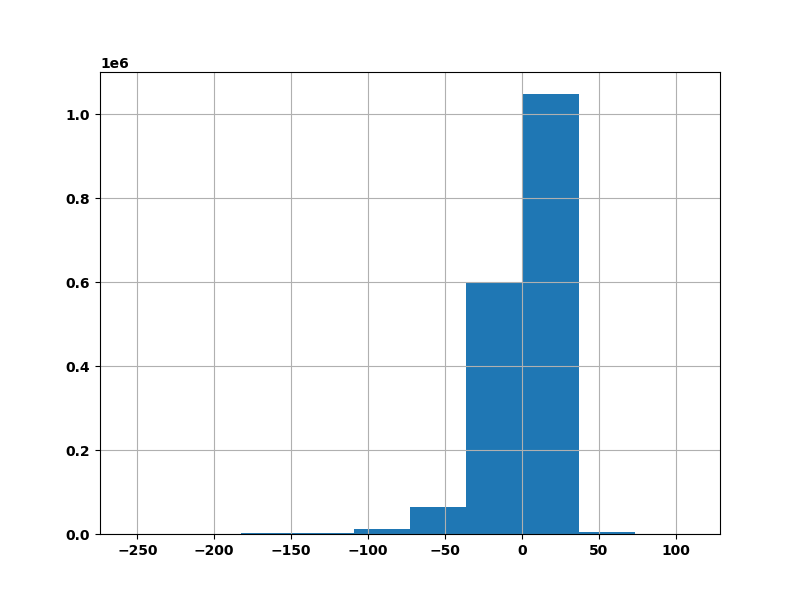

In [128]:
%matplotlib notebook
# test whether dataset contains gaussian distribution
df_train = df_train_cycles[['current', 'V']]
df_train['current'].hist()
plt.show()

In [111]:
# import tensorflow related libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [175]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# date-time parsing function for loading the dataset
# def parser(x):
#     return datetime.strptime('190'+x, '%Y-%m')

# Make dataset ready for LSTM
# [temporal input sequence: current sequences] [output: voltage(s)]
# example:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_supervised_univariate(df_feature, df_label, window_size=5):
    df_feature_as_np = df_feature.to_numpy()
    df_label_as_np = df_label.to_numpy()
    X = []
    y = []
    total_rows = len(df_feature_as_np) - window_size + 1
    for i in range(len(df_feature_as_np) - window_size):
        row = [[a] for a in df_feature_as_np[i:i+window_size]]
        X.append(row)
        label = df_label_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)


# input X and y are scaled
def pred_rmse(model, X, y, start=0, end=1000):
    yhat = model.predict(X)    #shape = (n, 1) where n= X.shape[0] eg number of total data points
    yhat = yhat.flatten()
    df = pd.DataFrame(data={'Predictions':yhat, 'Actuals':y})
    df_temp = pd.DataFrame()
    df_temp['counter'] = range(len(y))   # x axis for plot
    custom_plot.plot_dual_axis((df_temp['counter'], "Time"), (df['Predictions'][start:end], "Predicted voltage"), (df['Actuals'], "Actual voltage"))


    rmse = mean_squared_error(y, yhat, squared=False)
    mse = mean_squared_error(y, yhat)
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("MAPE: ", mape)
    return df_temp, rmse


# fit an LSTM network to training data
def fit_lstm(train_X, train_y, val_X, val_y, batch_size, nb_epoch, neurons, window_size):
    model = Sequential()
    model.add(InputLayer((window_size, 1)))   # each of training input are a window_size * 1 vector
    model.add(LSTM(neurons))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()
    
    # model save
    model_name = 'lstm_univar_window' + str(window_size)
    cp = ModelCheckpoint('models/' + model_name, monitor='val_loss', mode='min', save_best_only=True)  # save_best_only=true saves the best model with lowest validation loss
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

    # stop if val_loss not improve in 3 iterations
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=2,mode='min')  # min=minimize val_loss
    callback_list = [early_stopping, cp]

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)
    
    # load model with lowest validation loss
#     model = load_model('models/')
    
    return history, model



# fit an LSTM network to training data
def fit_lstm_multiple_parallel(train_X, train_y, val_X, val_y, batch_size, nb_epoch, neurons, window_size):
    model = Sequential()
    model.add(InputLayer((window_size, 1)))   # each of training input are a window_size * 1 vector
    model.add(LSTM(neurons))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()
    
    # model save
    model_name = 'lstm_univar_window' + str(window_size)
    cp = ModelCheckpoint('models/' + model_name, monitor='val_loss', mode='min', save_best_only=True)  # save_best_only=true saves the best model with lowest validation loss
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

    # stop if val_loss not improve in 3 iterations
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=2,mode='min')  # min=minimize val_loss
    callback_list = [early_stopping, cp]

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)
    
    # load model with lowest validation loss
#     model = load_model('models/')
    
    return history, model


# run a repeated experiment
# each dataframe argument to this function should be already scaled
def experiment(repeats, df_scaled_train, df_scaled_val, df_scaled_test, window_size=3):
    
    # convert to sequences and labels
    train_X, train_y = df_to_supervised_univariate(df_scaled_train['current'], df_scaled_train['V'], window_size)
    val_X, val_y = df_to_supervised_univariate(df_scaled_val['current'], df_scaled_val['V'], window_size)
    test_X, test_y = df_to_supervised_univariate(df_scaled_test['current'], df_scaled_test['V'], window_size)

    li_error_scores = list()
    li_history = list()
    li_models = list()
    li_predictions = list()


    for r in range(repeats):
       
        # fit the base model
        history, lstm_model = fit_lstm(train_X, train_y, val_X, val_y, 1, EPOCHS, NEURONS, window_size)

        li_history.append(history)
        li_models.append(lstm_model)

        df_yhat, rmse = pred_rmse(lstm_model, test_X, test_y, start=0, end=test_y.shape[0])  # prediction on test data

        # store forecast
        li_predictions.append(df_yhat)

        # report performance
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        li_error_scores.append(rmse)
        window_size += WIN_SIZE_INC    # window size increase

    return li_error_scores

# execute the experiment
def run(df_scaled_train, df_scaled_val, df_scaled_test):
    repeats = 1
    results = DataFrame()
    # run experiment
    timesteps = 1
    results['results'] = experiment(repeats, df_scaled_train, df_scaled_val, df_scaled_test)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_timesteps_1.csv', index=False)
    
# entry point with train, val and test data
df_train = df_train_cycles[['current', 'V']]
df_val = df_val_cycles[['current', 'V']]
df_test = df_test_cycles[['current', 'V']]

# normalize only input features
df_scaled_train = get_min_max_normalized_df(df_train, ['current'])
df_scaled_val = get_min_max_normalized_df(df_val, ['current'])
df_scaled_test = get_min_max_normalized_df(df_test, ['current'])

# set initial hyperparams
window_size = 3
WIN_SIZE_INC = 3
EPOCHS = 10
NEURONS = 64

run(df_scaled_train, df_scaled_val, df_scaled_test)

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_25572\2361999725.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
54310/54321 [============================>.] - ETA: 0s - loss: 0.1108 - root_mean_squared_error: 0.3328

INFO:tensorflow:Assets written to: models\lstm_univar_window3\assets


INFO:tensorflow:Assets written to: models\lstm_univar_window3\assets


54321/54321 [==============================] - 144s 3ms/step - loss: 0.1108 - root_mean_squared_error: 0.3328 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0930
Epoch 2/10
54314/54321 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0763

INFO:tensorflow:Assets written to: models\lstm_univar_window3\assets


INFO:tensorflow:Assets written to: models\lstm_univar_window3\assets


54321/54321 [==============================] - 191s 4ms/step - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0825
Epoch 3/10
54321/54321 [==============================] - 186s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 4/10
54321/54321 [==============================] - 183s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 5/10
54321/54321 [==============================] - 182s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 5: early stopping


ValueError: Per-column arrays must each be 1-dimensional

[4.1168 4.1167 4.1167 ... 4.0837 4.0837 4.0837]
[4.141237 4.141237 4.141237 ... 4.141237 4.141237 4.141237]


<IPython.core.display.Javascript object>


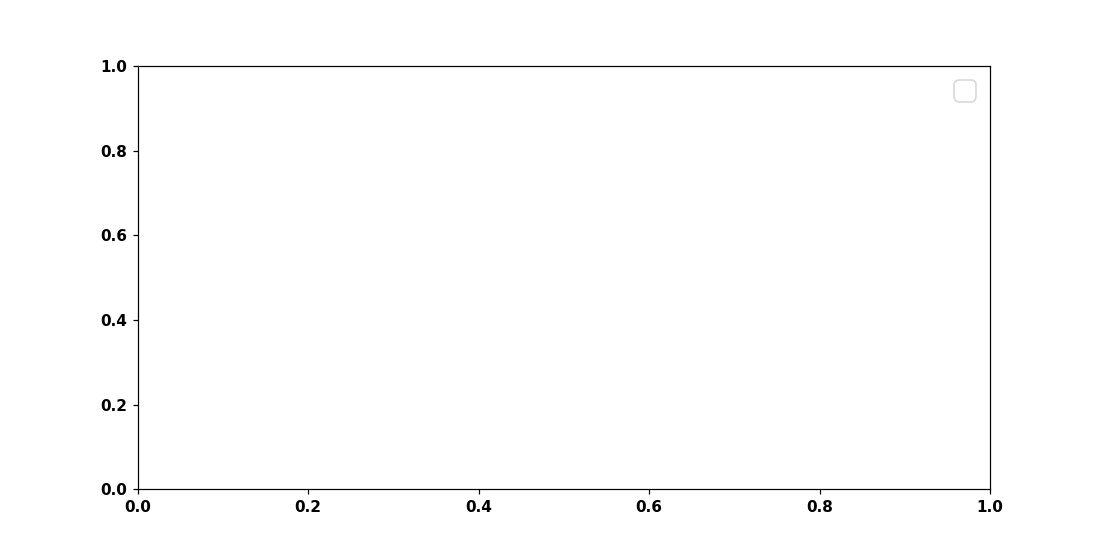

<IPython.core.display.Javascript object>


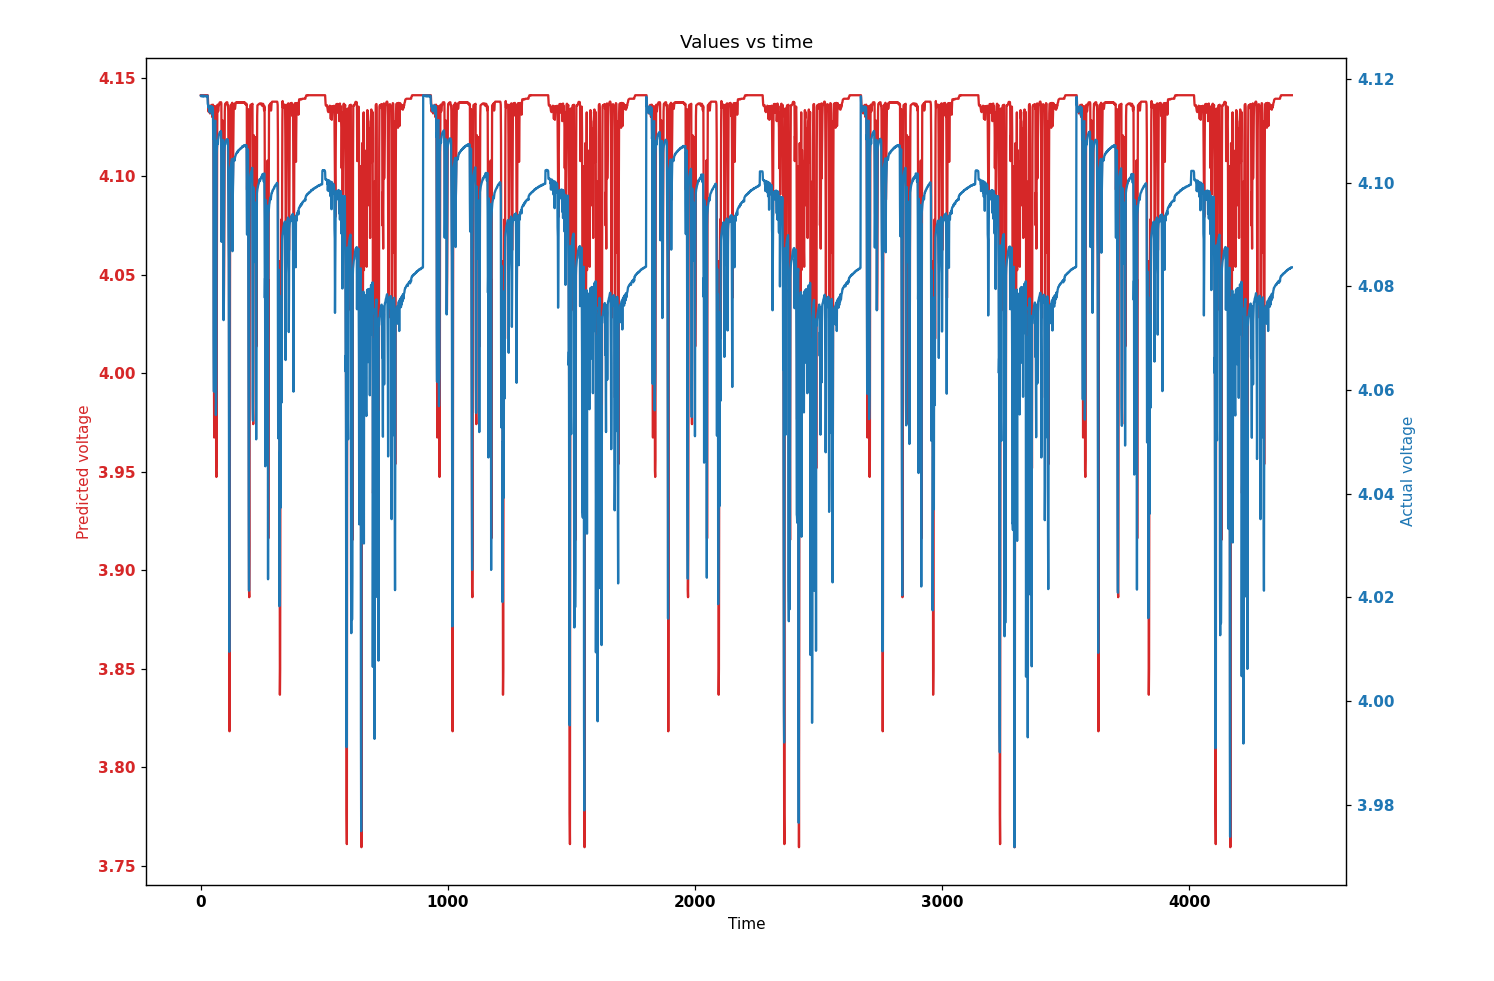

MSE:  0.0027118175770595395
RMSE:  0.052075114758006434
MAE:  0.04371274529462059
MAPE:  0.010706193023147554


In [199]:

df_scaled_test = get_min_max_normalized_df(df_test, ['current'])
test_X, test_y = df_to_supervised_univariate(df_scaled_test['current'], df_scaled_test['V'], window_size)

# load model with lowest validation loss
model = load_model('models/lstm_univar_window3/')
df_yhat, rmse = pred_rmse(model, test_X, test_y, start=0, end=test_y.shape[0])  # prediction on test data

In [56]:
# split dataset into train, tesTypeError: float() argument must be a string or a number, not 'StandardScaler'
t, validationTypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

X_train1, y_train1 = X1[:38000], y1[:38000]
X_val1, y_val1 = X1[38000:44000], y1[38000:44000]
X_test1, y_test1 = X1[44000:], y1[44000:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((38000, 5, 1), (38000,), (6000, 5, 1), (6000,), (5618, 5, 1), (5618,))

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))   # each of 38000 training input are a WINDOW_SIZE * 1 vector
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [58]:
# model 1
cp1 = ModelCheckpoint('model1/', save_best_only=True)         # save_best_only=true saves the best model with lowest validation loss
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [59]:
# measuers performance on every epoch on the validation dataset
# calls back checkpoint after every epoch and saves model if validation loss is lower than before
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
1173/1188 [============================>.] - ETA: 0s - loss: 1.8434 - root_mean_squared_error: 1.3577

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 8s 5ms/step - loss: 1.8209 - root_mean_squared_error: 1.3494 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 2/10
1185/1188 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0445

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0430
Epoch 3/10
1176/1188 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0432

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 4/10
1170/1188 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0409

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 5/10
1170/1188 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0369

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 6/10
1175/1188 [============================>.] - ETA: 0s - loss: 9.3600e-04 - root_mean_squared_error: 0.0306

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 9.3367e-04 - root_mean_squared_error: 0.0306 - val_loss: 8.0002e-04 - val_root_mean_squared_error: 0.0283
Epoch 7/10
1176/1188 [============================>.] - ETA: 0s - loss: 5.2076e-04 - root_mean_squared_error: 0.0228

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 5.1947e-04 - root_mean_squared_error: 0.0228 - val_loss: 3.1488e-04 - val_root_mean_squared_error: 0.0177
Epoch 8/10
1178/1188 [============================>.] - ETA: 0s - loss: 3.0194e-04 - root_mean_squared_error: 0.0174

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 3.0173e-04 - root_mean_squared_error: 0.0174 - val_loss: 2.3974e-04 - val_root_mean_squared_error: 0.0155
Epoch 9/10
1186/1188 [============================>.] - ETA: 0s - loss: 2.4048e-04 - root_mean_squared_error: 0.0155

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 2.4047e-04 - root_mean_squared_error: 0.0155 - val_loss: 2.2891e-04 - val_root_mean_squared_error: 0.0151
Epoch 10/10
1188/1188 [==============================] - 3s 3ms/step - loss: 2.3268e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.5939e-04 - val_root_mean_squared_error: 0.0161


In [60]:
# load model with lowest validation loss
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=False, dpi=200)

In [61]:
# prediction on training data
train_predictions = model1.predict(X_train1).flatten()   # flatten removes inner brackets in np array
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})   # dict: predicted: actual
train_results

Train Predictions  Actuals
0               4.137288   4.1400
1               4.136611   4.1400
2               4.136611   4.1400
3               4.136611   4.1401
4               4.136621   4.1400
...                  ...      ...
37995           4.143948   4.1476
37996           4.143847   4.1476
37997           4.143786   4.1478
37998           4.143812   4.1478
37999           4.143846   4.1479

[38000 rows x 2 columns]

In [25]:
%matplotlib notebook
# plt.plot(train_results['Train Predictions'][50:1000], 'b', label='Train Predictions')
# plt.plot(train_results['Actuals'][50:1000], 'r', label='Actuals')
plt.plot(train_results['Train Predictions'], 'b', label='Train Predictions')
plt.plot(train_results['Actuals'], 'r', label='Actuals')

NameError: name 'train_results' is not defined

In [65]:
# validation prediction
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

Val Predictions  Actuals
0            4.143853   4.1479
1            4.143915   4.1476
2            4.143950   4.1476
3            4.143921   4.1479
4            4.143913   4.1477
...               ...      ...
5995         4.123077   4.1257
5996         4.123063   4.1258
5997         4.123009   4.1257
5998         4.123027   4.1262
5999         4.123109   4.1260

[6000 rows x 2 columns]

In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

<IPython.core.display.Javascript object>


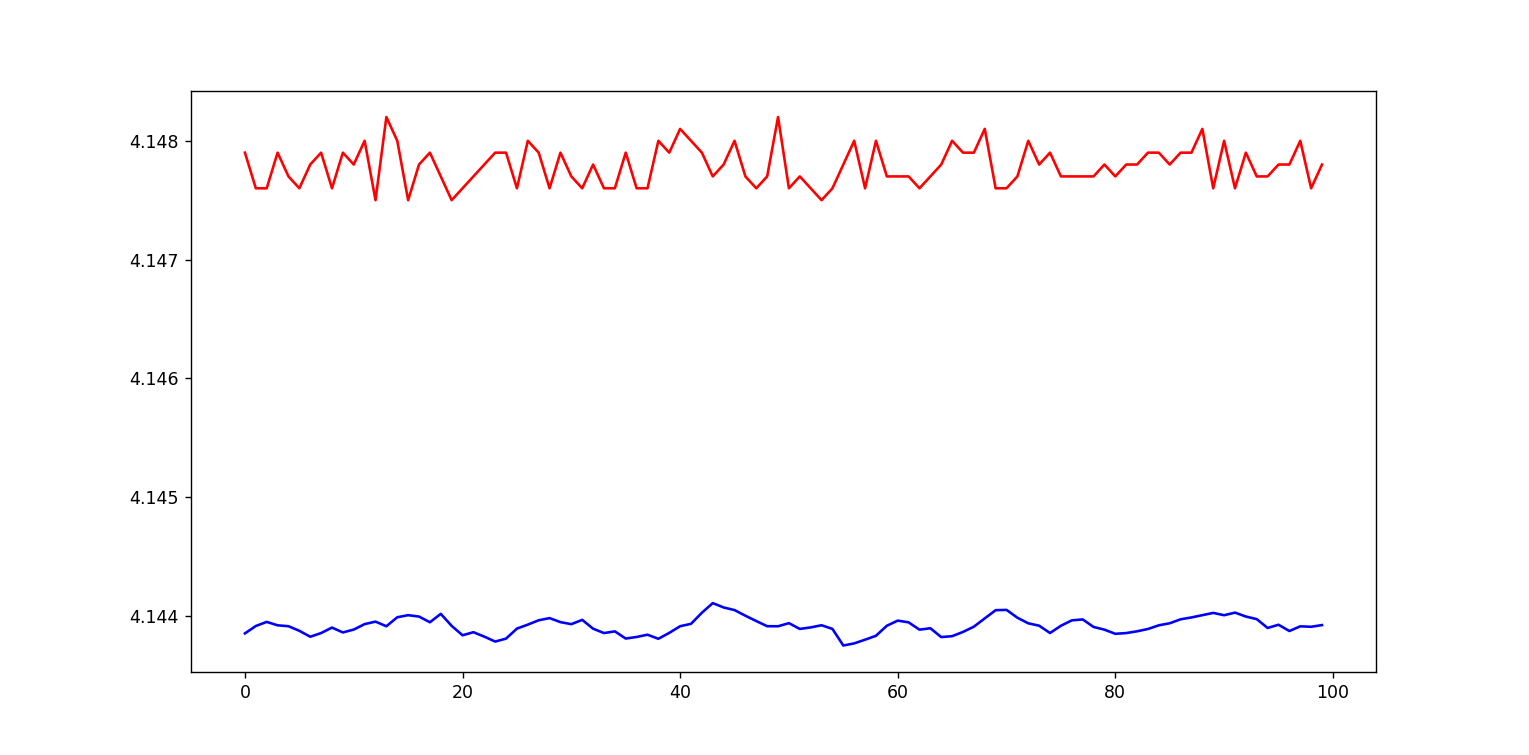

In [68]:
%matplotlib notebook
plt.plot(val_results['Val Predictions'][:100], 'b', label='Validation Predictions')
plt.plot(val_results['Actuals'][:100], 'r', label='Validation Actuals')

In [69]:
# test data was never seen by model
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

Test Predictions  Actuals
0             4.123289   4.1254
1             4.123293   4.1256
2             4.123262   4.1261
3             4.123292   4.1259
4             4.123216   4.1260
...                ...      ...
5613          4.083111   4.0836
5614          4.083121   4.0836
5615          4.083139   4.0836
5616          4.083160   4.0837
5617          4.083194   4.0837

[5618 rows x 2 columns]

<IPython.core.display.Javascript object>


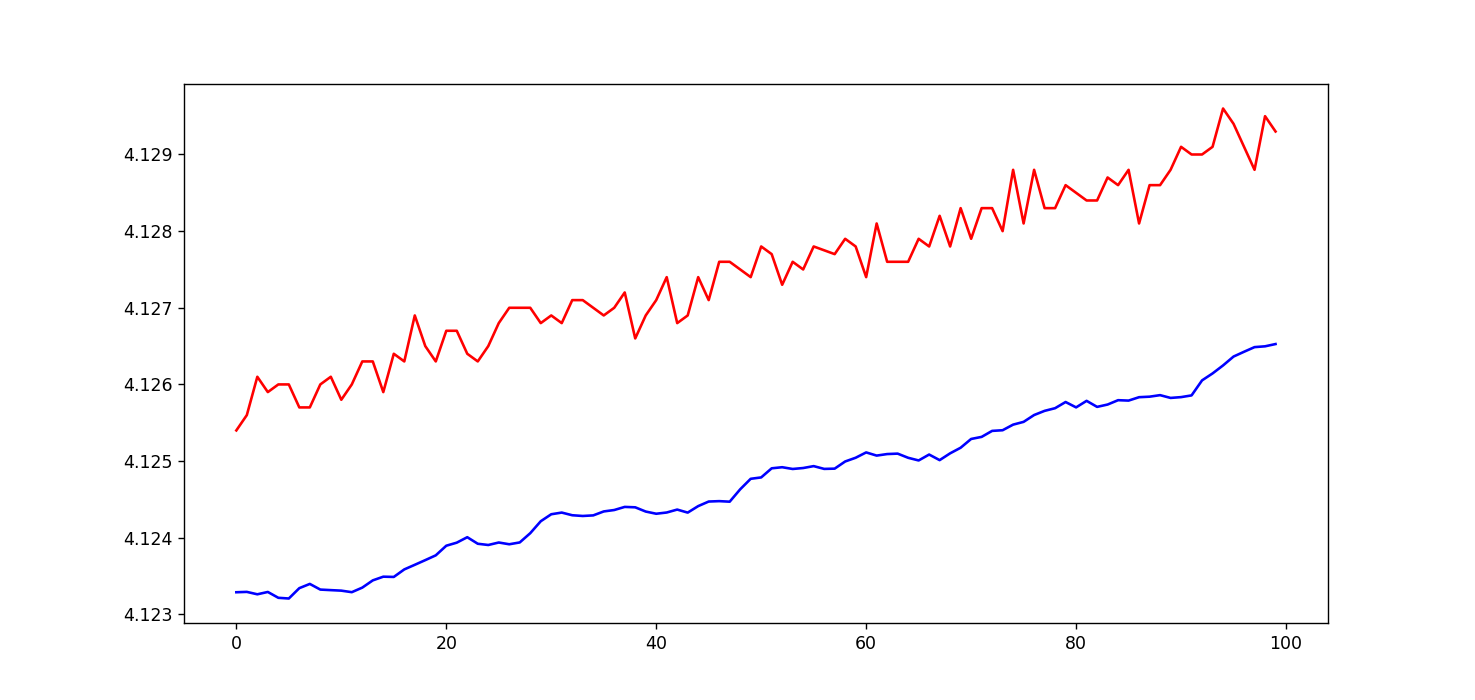

In [70]:
%matplotlib notebook
plt.plot(test_results['Test Predictions'][:100], 'b', label='Test Predictions')
plt.plot(test_results['Actuals'][:100], 'r', label='Test Actual')

### Multivariate: Use current, voltage, temperature (more variables can be added later)

Using time as variable: only relevant when seasonal properties/periodicity can be relevant

### Pre-processing: 
**Normalization vs Standardization**:
1. Normalization (MinMaxScalar) makes values between 0 and 1. If the maximum value is an outliar, it is not a good idea to use min max scalar becasue if the distribution is shrinked too narrow, min max scaling might affect the algorithm to treat outliars as more important 
2. Standardization makes mean=0 and standard deviation=1. If there are outliars, it is preserved in standardization ie it is still an outlier after processing

**Sparse data:**
This is when a lot of data in the dataset are meaningless/not significant i.e. zero (0) values. Centering sparse data i.e. using standard scaling would destroy the sparseness structure in the data, and thus rarely is a sensible thing to do. However, it can make sense to scale sparse inputs, especially if features are on different scales. If sparse data is present, then $with_mean=False$ can be used. Howver, for our data, sparsity does not exist so no need to worry about it.


In [19]:

cols = list(df_connected_V1)[1:4]    # column variables that are necessary for algo: voltage, current, mean temp
df_multivar_train = df_connected_V1[cols].astype(float)

print(df_multivar_train.head(5))
scaler = StandardScaler().fit(df_multivar_train)    # just fit, not transform yet
print(scaler)        # StandardScaler()

print('mean before standardization', scaler.mean_)     # mean
print('variance before standardization', scaler.scale_)    # variance

df_multivar_train_scaled = scaler.transform(df_multivar_train)

print('\nmean after standard scaling', df_multivar_train_scaled.mean(axis=0))     # mean, almost zero
print('standard deviation after standard scaling', df_multivar_train_scaled.std(axis=0))    # variance

# print(df_multivar_train_scaled[:20])   # This is a numpy array

# Make multivariate dataset ready for LSTM
# [temporal input sequence] [output]


# example:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def preprocess_time_sereis(df_as_np, input_window, output_window=1):
    X = []
    y = []
    for i in range(len(df_as_np) - input_window):
        X.append(df_as_np[i:i+input_window, 0:df_as_np.shape[1]])
#         print(df_as_np[i:i+input_window, 0:df_as_np.shape[1]])
        label = df_as_np[i+input_window][0]    # 0th index is voltage
        y.append(label)
    
    return np.array(X), np.array(y)

            V1  current  Temp_mean_module1
1096325  4.143      0.0               12.0
1096326  4.140      0.0               13.0
965787   4.140      0.0               13.0
965788   4.140      0.0               13.0
965789   4.140      0.0               13.0
StandardScaler()
mean before standardization [ 4.03478169 -3.00517905  9.57879915]
variance before standardization [ 0.11169335 27.3047484   2.1057379 ]

mean after standard scaling [ 2.68277385e-15 -4.00926921e-18 -2.86949125e-16]
standard deviation after standard scaling [1. 1. 1.]


In [20]:
output_window = 1    # how many values to predict/output label
input_window = 10    # map past 10 second values to the current output

print(df_multivar_train_scaled.shape)

X1, y1 = preprocess_time_sereis(df_multivar_train_scaled, input_window, output_window)
print(X1.shape, y1.shape)
# print(X1[1000:1005], y1[1000:1005])  # test

(49623, 3)
(49613, 10, 3) (49613,)


In [21]:
import math

# Train-validation-test split (60-20-20)
total_data_points = y1.shape[0]
train_total = math.floor(total_data_points * 0.6)
remaining = total_data_points - train_total
val_total = math.floor(remaining * 0.5)

X_train, y_train = X1[:train_total], y1[:train_total]
X_val, y_val = X1[train_total:train_total+val_total], y1[train_total:train_total+val_total]
X_test, y_test = X1[train_total+val_total:], y1[train_total+val_total:]
print(X_train.shape,y_train.shape)

(29767, 10, 3) (29767,)


In [24]:
print(X_train[0])
print(X_train[1])


[[0.96888774 0.11006068 1.14981112]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94292379 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]]
[[0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94292379 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]]


In [ ]:
print(X_train[0])


In [130]:
# Build model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# The architecture of the model has to be optimized later
model_LSTM_mutivariate = Sequential()
model_LSTM_mutivariate.add(InputLayer((X_train.shape[1], X_train.shape[2])))   # input_window, #input_variables
model_LSTM_mutivariate.add(LSTM(64))
model_LSTM_mutivariate.add(Dense(8, 'relu'))      # relu: make negative inputs zero, good for backpropagation and gradient-based methods
model_LSTM_mutivariate.add(Dense(1, 'linear'))    # output layer

model_LSTM_mutivariate.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                17408     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________


In [131]:
# model_LSTM_mutivariate
cp_LSTM_mutivariate = ModelCheckpoint('model_LSTM_mutivariate/', save_best_only=True)         # save_best_only=true saves the best model with lowest validation loss
model_LSTM_mutivariate.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Adam optimizer is better than classical stochastic gradient descent to update network weights iterative based in training data
# The loss function is used to optimize model. Here, MeanSquaredError function will get minimized by Adam optimizer
# Metric is used to judge the performance of model. This is only to look at and has nothing to do with the optimization process.

In [132]:
# measuers performance on every epoch on the validation dataset
# calls back checkpoint after every epoch and saves model if validation loss is lower than before

# stop if val_loss not improve in 2 iterations
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

history = model_LSTM_mutivariate.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp_LSTM_mutivariate])

# The batch size is a number of samples processed before the model is updated.
# The number of epochs is the number of complete passes through the training dataset.

Epoch 1/10
922/931 [============================>.] - ETA: 0s - loss: 0.1222 - root_mean_squared_error: 0.3495

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.1212 - root_mean_squared_error: 0.3481 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1513
Epoch 2/10
915/931 [============================>.] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1033

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0106 - root_mean_squared_error: 0.1032 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 3/10
917/931 [============================>.] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0903

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 4/10
927/931 [============================>.] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0845

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 5/10
926/931 [============================>.] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0802

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0945
Epoch 6/10
917/931 [============================>.] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0773

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920
Epoch 7/10
925/931 [============================>.] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0755

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 8/10
919/931 [============================>.] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0745

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 9/10
930/931 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0732

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 10/10
923/931 [============================>.] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0725

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866


<IPython.core.display.Javascript object>


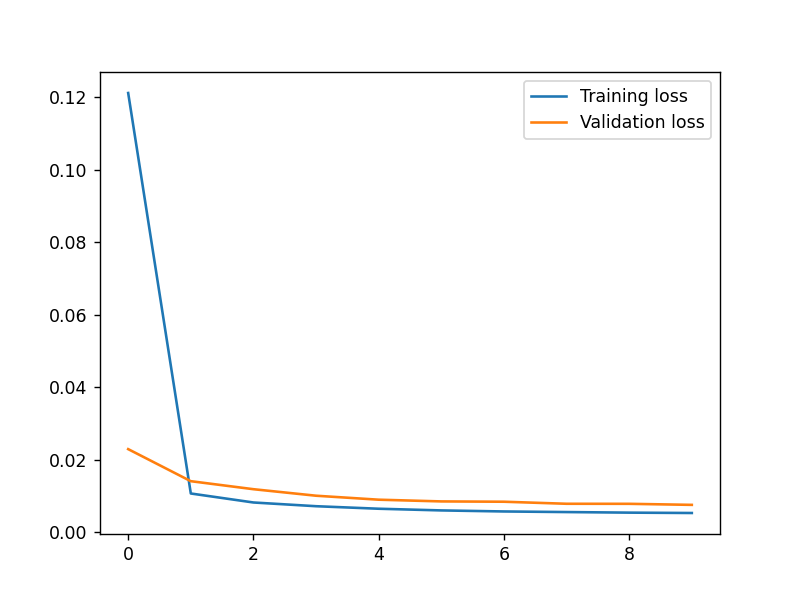

In [134]:
%matplotlib notebook
# plot train and val losss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [26]:
# load model with lowest validation loss
from tensorflow.keras.models import load_model
model_LSTM_mutivariate = load_model('model_LSTM_mutivariate/')

In [27]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X)    #shape = (n, 1) where n= X.shape[0] eg number of data points
    
    # Perform inverse transformation to rescale back to original range
    # Since we used 3 variables for transform, the inverse expects same dimensions
    # Therefore, copy same values 3 times and discard them after inverse transform
    prediction_copies = np.repeat(predictions, X.shape[2], axis=1)   # X.shape[2] is number of variables
    y_pred = scaler.inverse_transform(prediction_copies)[:,0]

    # print(y.shape)   # shape is (n,) e.g. 1D array
    y_actual = np.reshape(y, (y.shape[0], 1))    # make it 2D
    print(y_actual.shape)
    # reverse transform for actuals
    actual_copies = np.repeat(y_actual, X.shape[2], axis=1)   # X.shape[2] is number of variables
    y_actual = scaler.inverse_transform(actual_copies)[:,0]

    df = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_actual})
    df_temp = pd.DataFrame()
    df_temp['counter'] = range(len(y))   # x axis for plot
    custom_plot.plot_dual_axis((df_temp['counter'], "Time"), (df['Predictions'][start:end], "Predicted voltage"), (df['Actuals'], "Actual voltage"))
    print("MSE: ", mse(y, predictions))
    print("RMSE: ", mse(y, predictions, squared=False))
    print("MAE: ", mae(y, predictions))
    print("MAPE: ", mape(y, predictions))

(29767, 1)


<IPython.core.display.Javascript object>


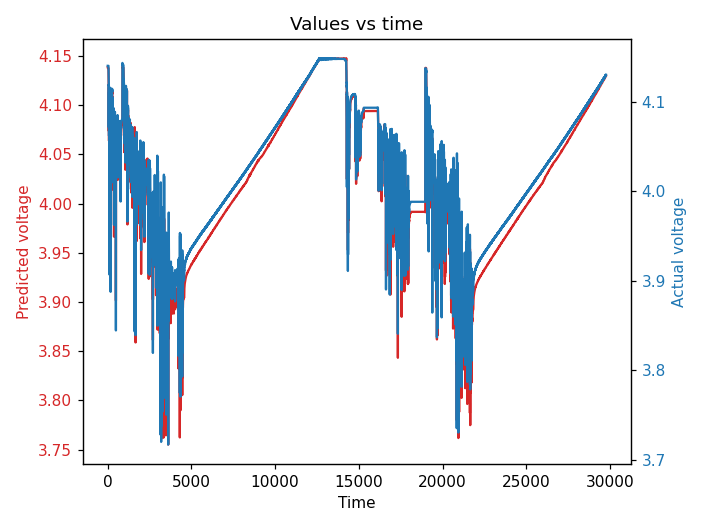

MSE:  0.005550639592784773
RMSE:  0.07450261467079376
MAE:  0.02807998622449949
MAPE:  0.16605621088365238
(9923, 1)


<IPython.core.display.Javascript object>


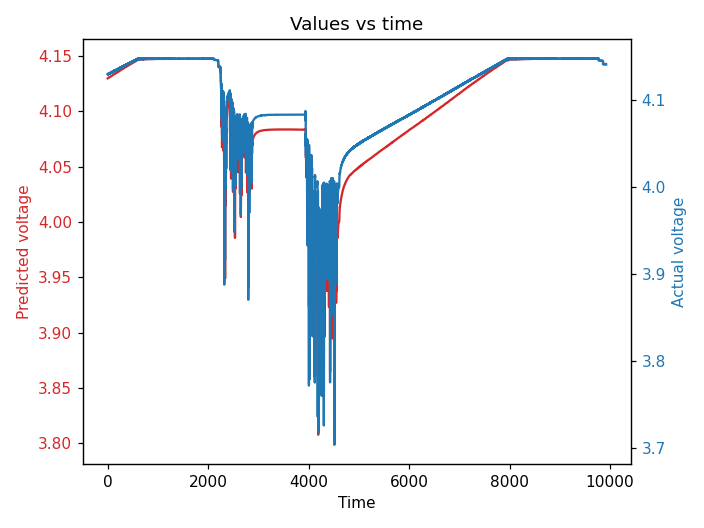

MSE:  0.0075079952002051285
RMSE:  0.08664868839287257
MAE:  0.018814740711785086
MAPE:  0.09230236292437387
(9923, 1)


<IPython.core.display.Javascript object>


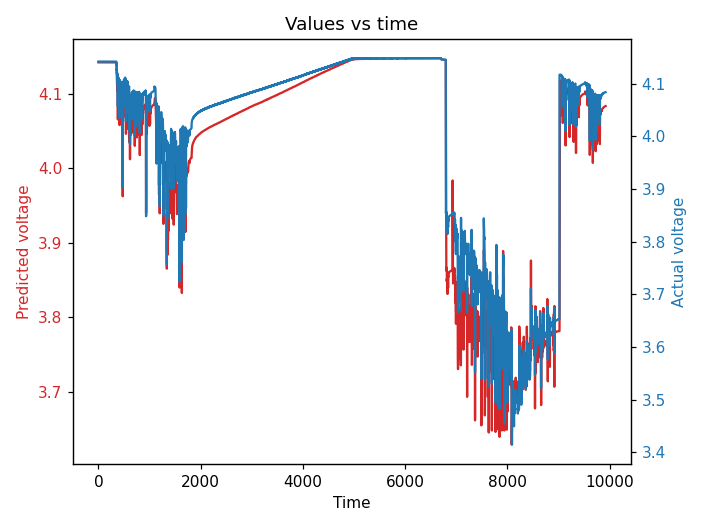

MSE:  0.27355820950535215
RMSE:  0.5230279242118456
MAE:  0.23272411277359303
MAPE:  0.38473911764893476


In [28]:
%matplotlib notebook

# scale 
plot_predictions1(model_LSTM_mutivariate, X_train, y_train, start=0, end=y_train.shape[0])  # prediction on training data
plot_predictions1(model_LSTM_mutivariate, X_val, y_val, start=0, end=y_train.shape[0])  # prediction on val data
plot_predictions1(model_LSTM_mutivariate, X_test, y_test, start=0, end=y_train.shape[0])  # prediction on test data

In [58]:
# Forecasting
# Apply rolling to foerrecast, the idea here: https://tsfresh.readthedocs.io/en/latest/text/forecasting.html
# Take a single data point and predict for that point, replace next actual data point with the predicted value, and move forward

# As prediction has to be done for each element, take the first data point
# np_input[0].reshape(np_input, (np_input[0].shape[0], 1))

def get_forecast_list(np_input, num_forecast, freeze=False):
    NUM_INPUT_VARS = np_input.shape[2]
    FREEZE_DURATION = 15*60    # how many seconds we want to freeze (ex 15 minutes)
    np_input_copy = np.empty((num_forecast, input_window, NUM_INPUT_VARS), float)

    for i in range(num_forecast):
        np_input_copy[i] = np_input[i]      # fill with actual values

    li_predicted = []
    # predict and append
    for i in range(num_forecast):
        pred_ID = i + input_window    # nth prediction
        # single_input empty array is necessary because LSTM prediction takes input in (num_datapoints, input_window, num_variables) format 
        single_input = np.empty((1, input_window, NUM_INPUT_VARS), float)

        # whereas np_input[0] is in (input_window, num_variables) format
        single_input[0] = np_input[i]
    #     single_input_last_index = single_input.shape[1] - 1      # index where voltage needs to be replaced with predictions
    #     print('single_input_last_index: ', single_input_last_index)
        if(len(li_predicted) > 0):
            # print('li_predicted: ', li_predicted)
            for j in range(1, len(li_predicted)+1):
                if(j <= input_window):           # max 10 values to replace as window size is 10
                    _, single_input[0][-j][0] = li_predicted[-j]  # replace from last to first

        predictions = model_LSTM_mutivariate.predict(single_input).flatten()    # flatten returns 1D array
        li_predicted.append((pred_ID, predictions[0]))   # tuple of (id, predicted_value)

    li_rolling_predictoins = []
    for time_id,predict_val in li_predicted:
        li_rolling_predictoins.append(predict_val)        

    # Current freezing
    if(freeze):
        # num_input_samples = np_input.shape[0]
        freeze_start_index = num_forecast - FREEZE_DURATION
        for i in range(freeze_start_index, num_forecast):
            for j in range(input_window):
                np_input_copy[i][j][1] = 0       # asisgn current = 0
        return np_input_copy, li_rolling_predictoins
    else:
        return li_rolling_predictoins


In [38]:
# print(list_predicted)
li_train_forecast = get_forecast_list(X_train, 900)           # 15 minute forecast
np_train_forecast = np.array(li_train_forecast)

li_val_forecast = get_forecast_list(X_val, 900)
np_val_forecast = np.array(li_val_forecast)

li_test_forecast = get_forecast_list(X_test, 900)
np_test_forecast = np.array(li_test_forecast)

(900, 1)


<IPython.core.display.Javascript object>


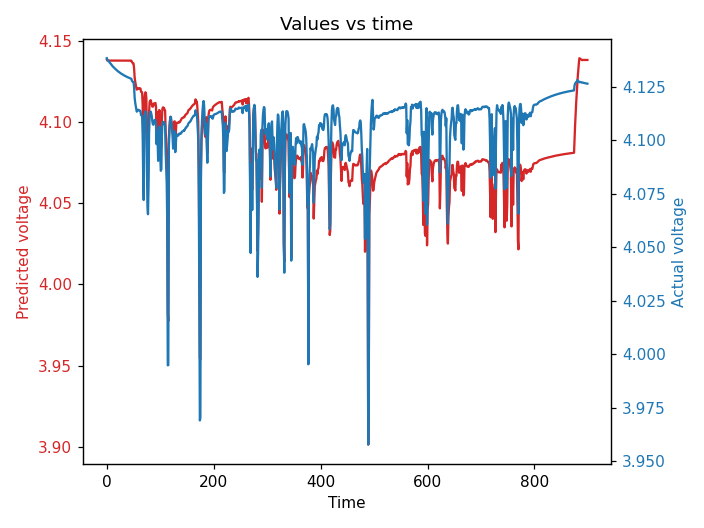

MSE:  0.06829942
RMSE:  0.26134157
MAE:  0.21990183
MAPE:  0.37917358
(900, 1)


<IPython.core.display.Javascript object>


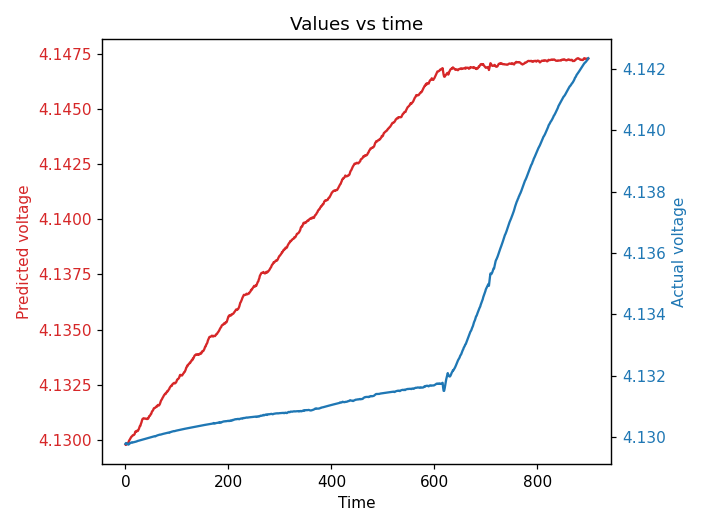

MSE:  0.006988317
RMSE:  0.083596155
MAE:  0.07475703
MAPE:  0.08510988
(900, 1)


<IPython.core.display.Javascript object>


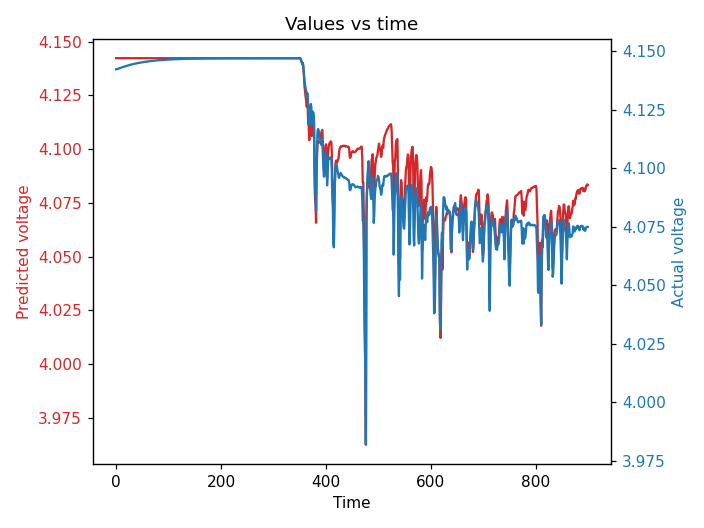

MSE:  0.0038067787
RMSE:  0.0616991
MAE:  0.052464508
MAPE:  0.1444296


In [40]:
%matplotlib notebook

# Example: take first 900 values
plot_predictions1(model_LSTM_mutivariate, X_train[:900], np_train_forecast, start=0, end=y_train.shape[0])  # rolling forecast on training data
plot_predictions1(model_LSTM_mutivariate, X_val[:900], np_val_forecast, start=0, end=y_train.shape[0])  # rolling forecast on val data
plot_predictions1(model_LSTM_mutivariate, X_test[:900], np_test_forecast, start=0, end=y_train.shape[0])  # rolling forecast on test data

In [59]:
# Test current freezing
forecast_sec = 2*3600
np_frozen_input, li_forecast_freeze = get_forecast_list(X_test, forecast_sec, True)           # 2 hour forecast
np_test_forecast_freeze = np.array(li_forecast_freeze)

(7200, 1)


<IPython.core.display.Javascript object>


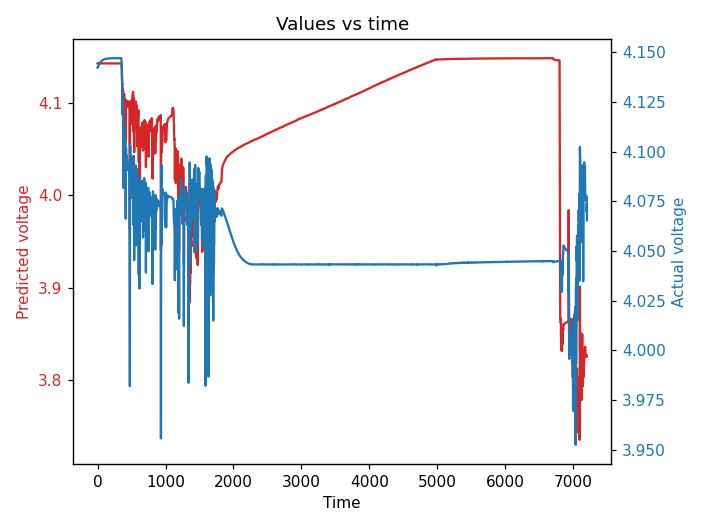

MSE:  0.61308336
RMSE:  0.7829964
MAE:  0.6287564
MAPE:  8.592644


In [60]:
%matplotlib notebook

# test forecast with input freezing
plot_predictions1(model_LSTM_mutivariate, np_frozen_input[:forecast_sec], np_test_forecast_freeze, start=0, end=forecast_sec)  # rolling forecast on test data

## predict with 1D convolution

In [187]:
model_conv = Sequential()
model_conv.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model_conv.add(Conv1D(64, kernel_size=2))
model_conv.add(Flatten())
model_conv.add(Dense(8, 'relu'))
model_conv.add(Dense(1, 'linear'))

model_conv.summary()

cp_conv = ModelCheckpoint('model_conv/', save_best_only=True)
model_conv.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 9, 64)             448       
                                                                 
 flatten_5 (Flatten)         (None, 576)               0         
                                                                 
 dense_20 (Dense)            (None, 8)                 4616      
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,073
Trainable params: 5,073
Non-trainable params: 0
_________________________________________________________________


In [188]:
history_conv = model_conv.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp_conv])

Epoch 1/20
872/931 [===========================>..] - ETA: 0s - loss: 0.0548 - root_mean_squared_error: 0.2340INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 2s 2ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 2/20
914/931 [============================>.] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0914INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0084 - root_mean_squared_error: 0.0919 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 3/20
923/931 [============================>.] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0809INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0919
Epoch 4/20
899/931 [===========================>..] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0821INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 5/20
880/931 [===========================>..] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0771INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 2ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 6/20
911/931 [============================>.] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0822INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866
Epoch 7/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 8/20
928/931 [============================>.] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0758INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 9/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0863
Epoch 10/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0863
Epoch 11/20
894/931 [===========================>..] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0782INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853
Epoch 12/20
883/931 [===========================>..] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0774INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 13/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 14/20
931/931 [==============================] - 1s 984us/step - loss: 0.0061 - root_mean_squared_error: 0.0783 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 15/20
919/931 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0759INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841
Epoch 16/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0056 - root_mean_squared_error: 0.0752 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 17/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 18/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 19/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 20/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0074 - val_root_m

<IPython.core.display.Javascript object>


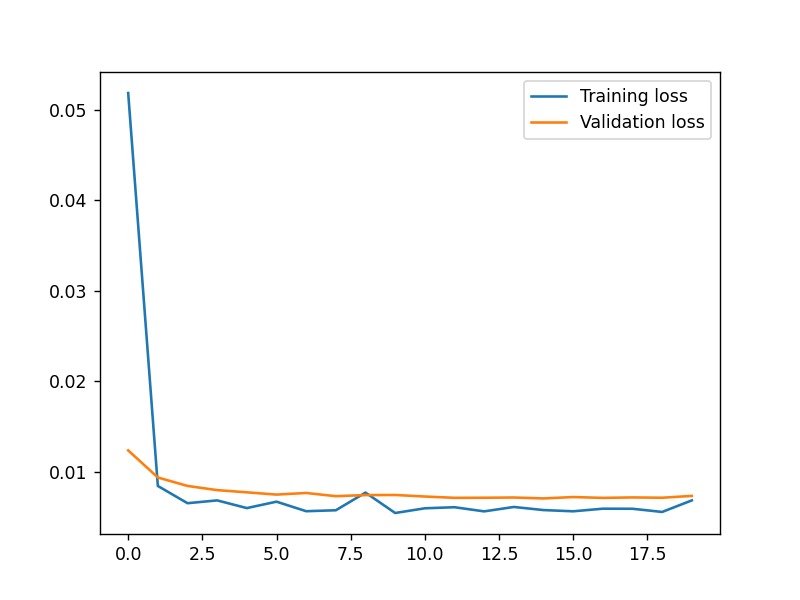

In [189]:
%matplotlib notebook
# plot train and val losss
plt.plot(history_conv.history['loss'], label='Training loss')
plt.plot(history_conv.history['val_loss'], label='Validation loss')
plt.legend()

In [190]:
# load model with lowest validation loss
from tensorflow.keras.models import load_model
model_conv = load_model('model_conv/')

(29767, 1)


<IPython.core.display.Javascript object>


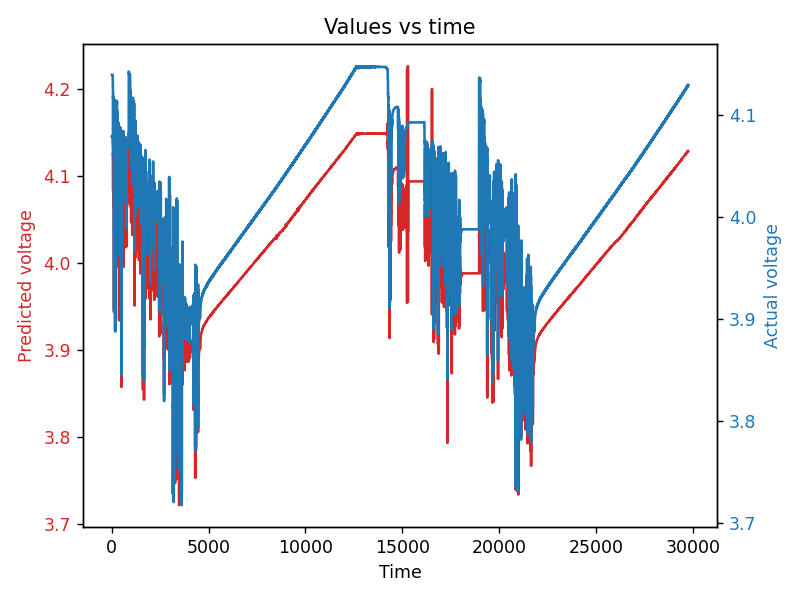

Mean squared error:  0.005293418688104565
(9923, 1)


<IPython.core.display.Javascript object>


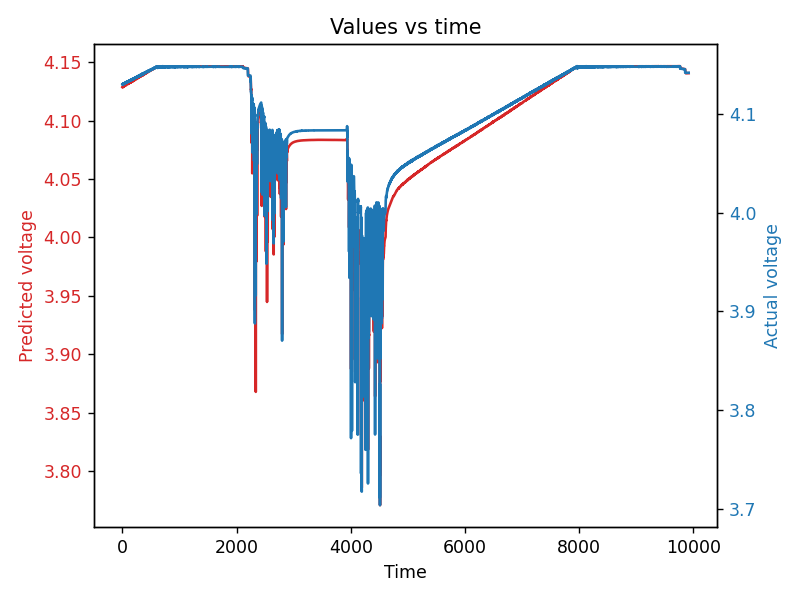

Mean squared error:  0.007070513882651092
(9923, 1)


<IPython.core.display.Javascript object>


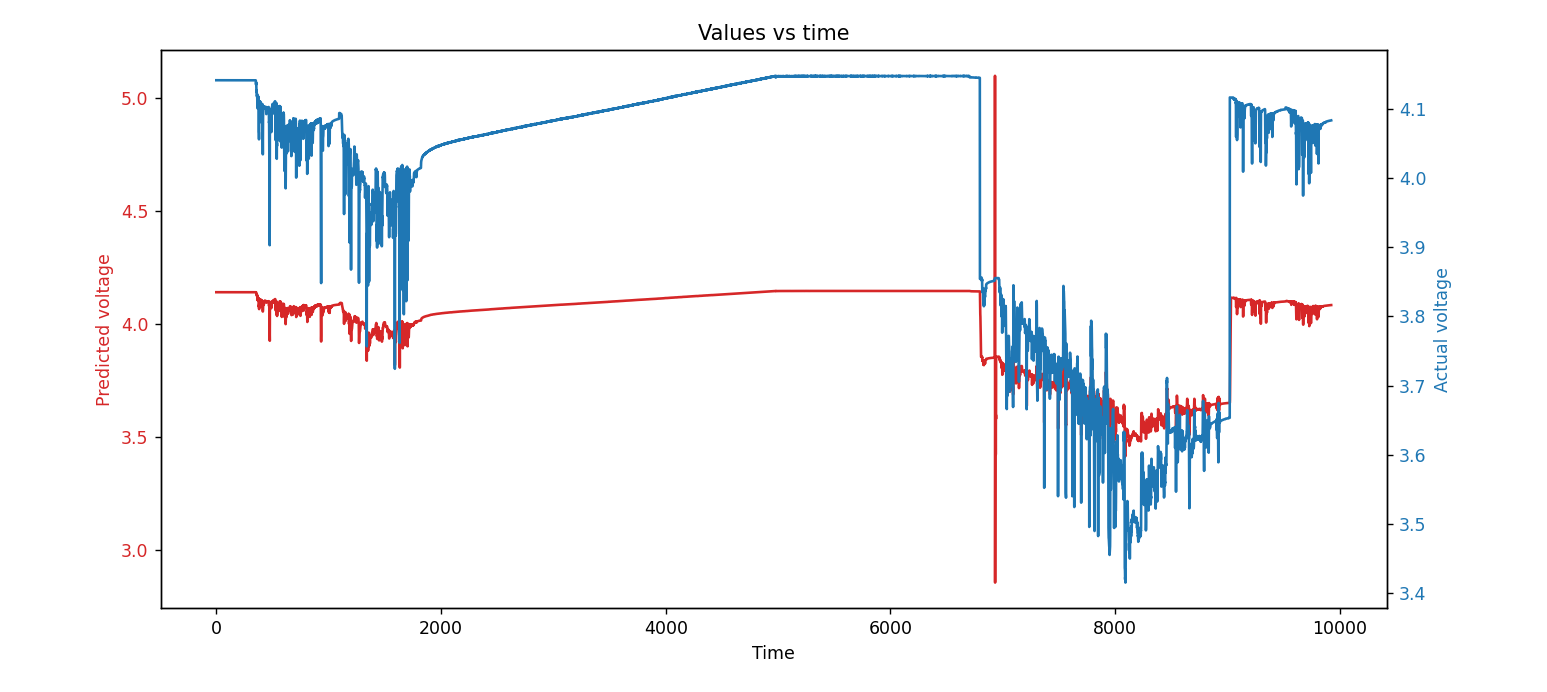

Mean squared error:  0.04589616182537113


In [191]:
%matplotlib notebook

# scale 
plot_predictions1(model_conv, X_train, y_train, start=0, end=y_train.shape[0])  # prediction on training data
plot_predictions1(model_conv, X_val, y_val, start=0, end=y_train.shape[0])  # prediction on val data
plot_predictions1(model_conv, X_test, y_test, start=0, end=y_train.shape[0])  # prediction on test data

## GRU model

In [192]:
model_GRU = Sequential()
model_GRU.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model_GRU.add(GRU(64))
model_GRU.add(Dense(8, 'relu'))
model_GRU.add(Dense(1, 'linear'))
model_GRU.summary()

cp_GRU = ModelCheckpoint('model_GRU/', save_best_only=True)
model_GRU.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                13248     
                                                                 
 dense_22 (Dense)            (None, 8)                 520       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,777
Trainable params: 13,777
Non-trainable params: 0
_________________________________________________________________


In [193]:
history_GRU = model_GRU.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp_GRU])

Epoch 1/10
920/931 [============================>.] - ETA: 0s - loss: 0.0862 - root_mean_squared_error: 0.2936

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 7s 6ms/step - loss: 0.0853 - root_mean_squared_error: 0.2921 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 2/10
926/931 [============================>.] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0808

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0914
Epoch 3/10
931/931 [==============================] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0753

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 4/10
925/931 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0736

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 5/10
919/931 [============================>.] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0724

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 6/10
931/931 [==============================] - 4s 4ms/step - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866
Epoch 7/10
918/931 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0710

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 8/10
925/931 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0708

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 9/10
915/931 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0705

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 10/10
925/931 [============================>.] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0702

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838


<IPython.core.display.Javascript object>


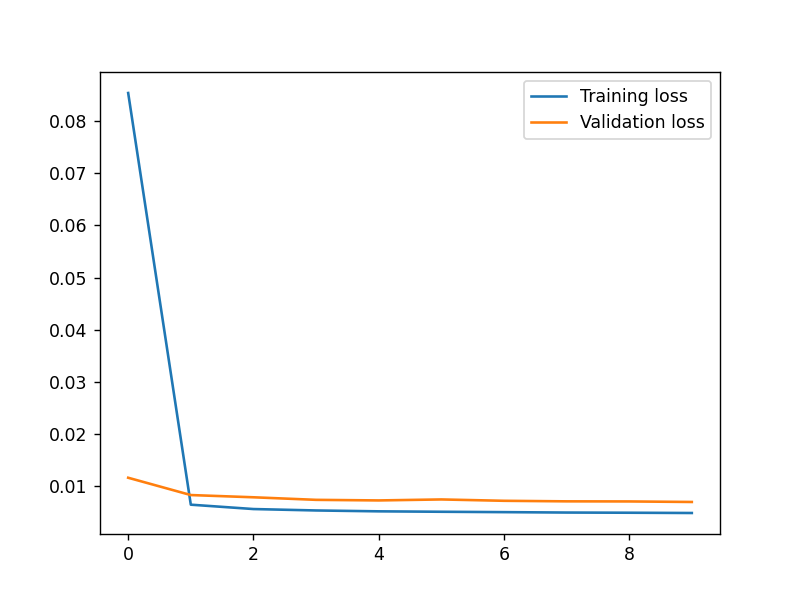

In [194]:
%matplotlib notebook
# plot train and val losss
plt.plot(history_GRU.history['loss'], label='Training loss')
plt.plot(history_GRU.history['val_loss'], label='Validation loss')
plt.legend()

In [196]:
# load model with lowest validation loss
from tensorflow.keras.models import load_model
model_GRU = load_model('model_GRU/')

(29767, 1)


<IPython.core.display.Javascript object>


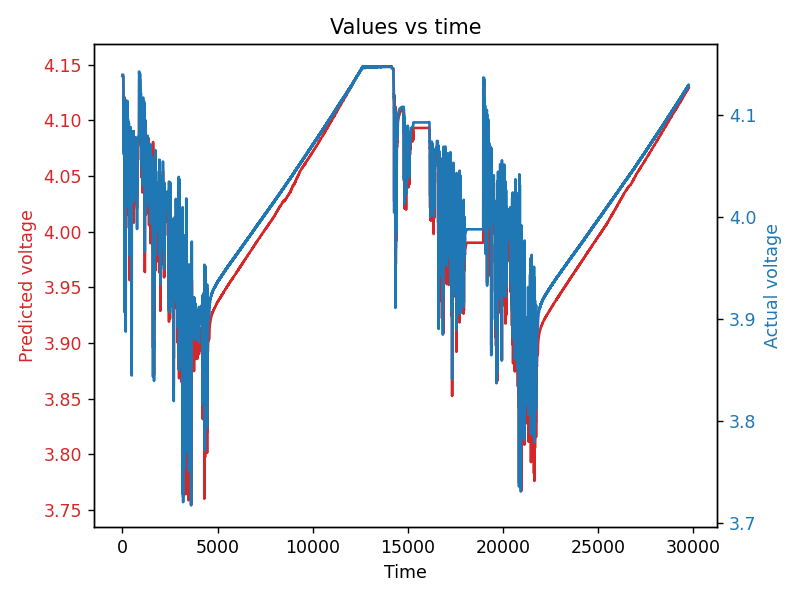

Mean squared error:  0.004961927294454731
(9923, 1)


<IPython.core.display.Javascript object>


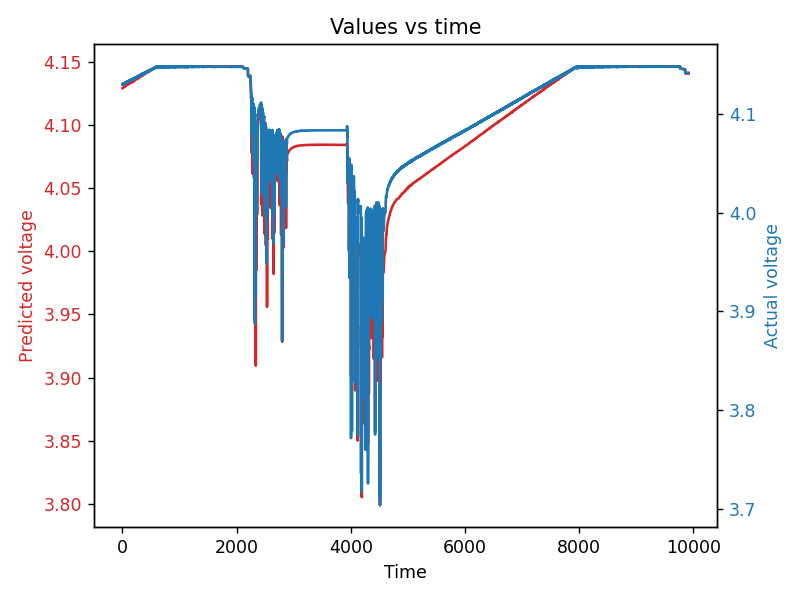

Mean squared error:  0.0070223856760246815
(9923, 1)


<IPython.core.display.Javascript object>


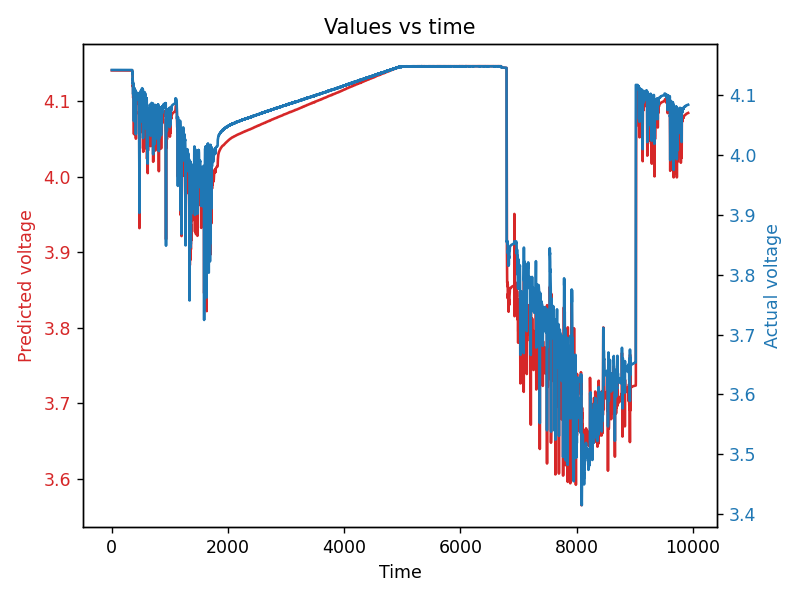

Mean squared error:  0.1267739471022983


In [197]:
%matplotlib notebook

# scale 
plot_predictions1(model_GRU, X_train, y_train, start=0, end=y_train.shape[0])  # prediction on training data
plot_predictions1(model_GRU, X_val, y_val, start=0, end=y_train.shape[0])  # prediction on val data
plot_predictions1(model_GRU, X_test, y_test, start=0, end=y_train.shape[0])  # prediction on test data

## LSTM with 

In [ ]:
model6 = Sequential()
model6.add(InputLayer((7, 6)))
model6.add(LSTM(32, return_sequences=True))
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(2, 'linear'))

model6.summary()

In [ ]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model6.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp6])

In [ ]:
model7 = Sequential()
model7.add(InputLayer((7, 6)))
model7.add(Conv1D(64, kernel_size=2, activation='relu'))
model7.add(Flatten())
model7.add(Dense(8, 'relu'))
model7.add(Dense(2, 'linear'))
model7.summary()

cp7 = ModelCheckpoint('model6/', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model7.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp7])